# Customer Segmentation Analysis - CHIP

The Category Manager for Chips at a leading supermarket chain has approached Quantium’s retail analytics team to gain a deeper understanding of customer purchasing behavior within the chip category across the region. The goal is to leverage transactional and customer data to uncover insights that will inform the supermarket’s strategic planning for the chip category over the next six months.

The project requires:

1. Data Cleaning and Preparation: Ensuring transactional and customer datasets are consistent, accurate, and free of anomalies (e.g., missing data, outliers, misidentified category items).

2. Analysis of Purchasing Behavior: Identifying key drivers of chip sales, trends, and patterns in customer purchases, including pack size preferences, frequency, and brand loyalty.

3. Customer Segmentation: Categorizing customers based on purchasing behavior to determine actionable segments and strategies to target each group effectively.

4. Strategic Recommendations: Providing data-driven insights and recommendations on how the supermarket can optimize chip sales, increase customer engagement, and drive profitability within the category.

The outcomes of this analysis will equip the supermarket with actionable insights into customer preferences and behaviors, enabling targeted marketing strategies and better product positioning for the upcoming half-year period.

## Data Exploration

In [1]:
# Data Manipulation and Analysis
import pandas as pd
import numpy as np

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Handling Date and Time
from datetime import datetime, timedelta

# Machine Learning (if customer segmentation requires clustering, e.g., KMeans)
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# To suppress warnings (optional, for cleaner outputs)
import warnings
warnings.filterwarnings("ignore")

# Display settings (optional, for better dataframe visualization)
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

print("Libraries imported successfully!")


Libraries imported successfully!


In [2]:
transaction_data = pd.read_csv("QVI_transaction_data(in).csv")
purchase_behaviour_data = pd.read_csv("QVI_purchase_behaviour.csv")


In [3]:
transaction_data.head()

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES
0,43390,1,1000,1,5,Natural Chip Compny SeaSalt175g,2,6.00
1,43599,1,1307,348,66,CCs Nacho Cheese 175g,3,6.30
2,43605,1,1343,383,61,Smiths Crinkle Cut Chips Chicken 170g,2,2.90
3,43329,2,2373,974,69,Smiths Chip Thinly S/Cream&Onion 175g,5,15.00
4,43330,2,2426,1038,108,Kettle Tortilla ChpsHny&Jlpno Chili 150g,3,13.80


In [4]:
transaction_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264836 entries, 0 to 264835
Data columns (total 8 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   DATE            264836 non-null  int64  
 1   STORE_NBR       264836 non-null  int64  
 2   LYLTY_CARD_NBR  264836 non-null  int64  
 3   TXN_ID          264836 non-null  int64  
 4   PROD_NBR        264836 non-null  int64  
 5   PROD_NAME       264836 non-null  object 
 6   PROD_QTY        264836 non-null  int64  
 7   TOT_SALES       264836 non-null  float64
dtypes: float64(1), int64(6), object(1)
memory usage: 16.2+ MB


In [5]:
transaction_data.shape

(264836, 8)

In [6]:
purchase_behaviour_data.head()

,LYLTY_CARD_NBR,LIFESTAGE,PREMIUM_CUSTOMER
0,1000,YOUNG SINGLES/COUPLES,Premium
1,1002,YOUNG SINGLES/COUPLES,Mainstream
2,1003,YOUNG FAMILIES,Budget
3,1004,OLDER SINGLES/COUPLES,Mainstream
4,1005,MIDAGE SINGLES/COUPLES,Mainstream


In [7]:
purchase_behaviour_data.shape

(72637, 3)

In [8]:
purchase_behaviour_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72637 entries, 0 to 72636
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   LYLTY_CARD_NBR    72637 non-null  int64 
 1   LIFESTAGE         72637 non-null  object
 2   PREMIUM_CUSTOMER  72637 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.7+ MB


In [9]:
purchase_behaviour_data.nunique()

LYLTY_CARD_NBR      72637
LIFESTAGE               7
PREMIUM_CUSTOMER        3
dtype: int64

In [10]:
transaction_data.nunique()

DATE                 364
STORE_NBR            272
LYLTY_CARD_NBR     72637
TXN_ID            263127
PROD_NBR             114
PROD_NAME            114
PROD_QTY               6
TOT_SALES            112
dtype: int64

In [11]:
# SInce there are  unique Loyalty Card numbers,
# We can derive that on average one person made 264836/72637 (3.6) purchases over the years

## Data Cleaning and Transformation

In [12]:
# Convert date from Excel Date System to Standard date 

def convert_date(excel_date):
    excel_start_date = datetime(1900,1,1)
    standard_date = excel_start_date + timedelta(days = excel_date-2)
    return standard_date

In [13]:
transaction_data['DATE'] = transaction_data['DATE'].apply(convert_date)

In [14]:
# I'll use regular expression to define a function that 
# sextract the necessary information from the prod_name column such as the brand Name, product nameand size

In [15]:
import re

def extract_prod_info(prod_name):
    match = re.match(r"(.+?)\s+(.+?)(\d+)g", prod_name)
    if match:
        brand = match.group(1).strip()  # First part before the first space
        product = match.group(2).strip()  # Middle part
        size = int(match.group(3).strip())  # Convert the numeric size to int
        return brand, product, size
    else:
        return None, None, None  
    


In [16]:
transaction_data[["BRAND", "PRODUCT", "SIZE"]] = transaction_data['PROD_NAME'].apply(lambda x: pd.Series(extract_prod_info(x)))

In [17]:
transaction_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264836 entries, 0 to 264835
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   DATE            264836 non-null  datetime64[ns]
 1   STORE_NBR       264836 non-null  int64         
 2   LYLTY_CARD_NBR  264836 non-null  int64         
 3   TXN_ID          264836 non-null  int64         
 4   PROD_NBR        264836 non-null  int64         
 5   PROD_NAME       264836 non-null  object        
 6   PROD_QTY        264836 non-null  int64         
 7   TOT_SALES       264836 non-null  float64       
 8   BRAND           258772 non-null  object        
 9   PRODUCT         258772 non-null  object        
 10  SIZE            258772 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(5), object(3)
memory usage: 22.2+ MB


In [18]:
transaction_data.head()

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,BRAND,PRODUCT,SIZE
0,2018-10-17,1,1000,1,5,Natural Chip Compny SeaSalt175g,2,6.00,Natural,Chip Compny SeaSalt,175.00
1,2019-05-14,1,1307,348,66,CCs Nacho Cheese 175g,3,6.30,CCs,Nacho Cheese,175.00
2,2019-05-20,1,1343,383,61,Smiths Crinkle Cut Chips Chicken 170g,2,2.90,Smiths,Crinkle Cut Chips Chicken,170.00
3,2018-08-17,2,2373,974,69,Smiths Chip Thinly S/Cream&Onion 175g,5,15.00,Smiths,Chip Thinly S/Cream&Onion,175.00
4,2018-08-18,2,2426,1038,108,Kettle Tortilla ChpsHny&Jlpno Chili 150g,3,13.80,Kettle,Tortilla ChpsHny&Jlpno Chili,150.00


In [19]:
transaction_data.describe(include="all")

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,BRAND,PRODUCT,SIZE
count,264836,264836.00,264836.00,264836.00,264836.00,264836,264836.00,264836.00,258772,258772,258772.00
unique,NaN,NaN,NaN,NaN,NaN,114,NaN,NaN,29,109,NaN
top,NaN,NaN,NaN,NaN,NaN,Kettle Mozzarella Basil & Pesto 175g,NaN,NaN,Kettle,Cheese,NaN
freq,NaN,NaN,NaN,NaN,NaN,3304,NaN,NaN,41288,6264,NaN
mean,2018-12-30 00:52:12.879215616,135.08,135549.48,135158.31,56.58,NaN,1.91,7.30,NaN,NaN,181.07
min,2018-07-01 00:00:00,1.00,1000.00,1.00,1.00,NaN,1.00,1.50,NaN,NaN,35.00
25%,2018-09-30 00:00:00,70.00,70021.00,67601.50,28.00,NaN,2.00,5.40,NaN,NaN,150.00
50%,2018-12-30 00:00:00,130.00,130357.50,135137.50,56.00,NaN,2.00,7.40,NaN,NaN,170.00
75%,2019-03-31 00:00:00,203.00,203094.25,202701.25,85.00,NaN,2.00,9.20,NaN,NaN,175.00
max,2019-06-30 00:00:00,272.00,2373711.00,2415841.00,114.00,NaN,200.00,650.00,NaN,NaN,380.00


In [20]:
transaction_data['PROD_NAME'].isnull().sum()

0

In [21]:
transaction_data.tail()

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,BRAND,PRODUCT,SIZE
264831,2019-03-09,272,272319,270088,89,Kettle Sweet Chilli And Sour Cream 175g,2,10.80,Kettle,Sweet Chilli And Sour Cream,175.00
264832,2018-08-13,272,272358,270154,74,Tostitos Splash Of Lime 175g,1,4.40,Tostitos,Splash Of Lime,175.00
264833,2018-11-06,272,272379,270187,51,Doritos Mexicana 170g,2,8.80,Doritos,Mexicana,170.00
264834,2018-12-27,272,272379,270188,42,Doritos Corn Chip Mexican Jalapeno 150g,2,7.80,Doritos,Corn Chip Mexican Jalapeno,150.00
264835,2018-09-22,272,272380,270189,74,Tostitos Splash Of Lime 175g,2,8.80,Tostitos,Splash Of Lime,175.00


In [22]:
# Looks like there are sime fields missing in the brand, product and size category.
print(transaction_data['SIZE'].isnull().sum())
print(transaction_data['SIZE'].isnull().sum()/264836)

6064
0.022897189203884668


In [23]:
#The missing data is less than one percent of the whole data, Hence, I'll drop the rows for more accurate analysis
transaction_data = transaction_data.dropna(axis=0)

<Axes: ylabel='TOT_SALES'>

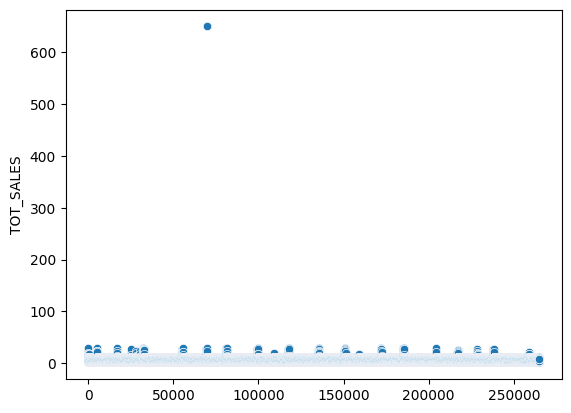

In [24]:
#Let's search for outliers
sns.scatterplot(transaction_data['TOT_SALES'])

<Axes: ylabel='PROD_QTY'>

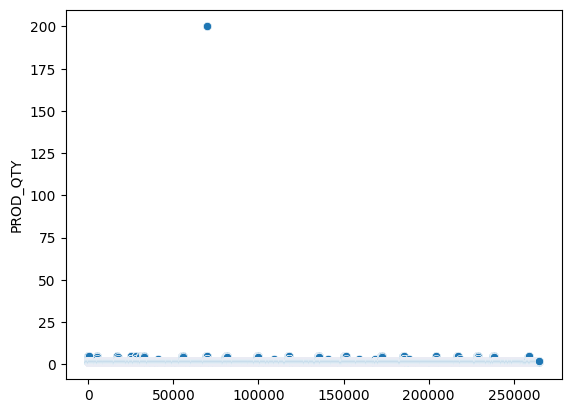

In [25]:
sns.scatterplot(transaction_data['PROD_QTY'])

In [26]:
transaction_data[transaction_data['TOT_SALES']>100]

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,BRAND,PRODUCT,SIZE
69762,2018-08-19,226,226000,226201,4,Dorito Corn Chp Supreme 380g,200,650.00,Dorito,Corn Chp Supreme,380.00
69763,2019-05-20,226,226000,226210,4,Dorito Corn Chp Supreme 380g,200,650.00,Dorito,Corn Chp Supreme,380.00


In [27]:
transaction_data[transaction_data['PROD_QTY']>25]

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,BRAND,PRODUCT,SIZE
69762,2018-08-19,226,226000,226201,4,Dorito Corn Chp Supreme 380g,200,650.00,Dorito,Corn Chp Supreme,380.00
69763,2019-05-20,226,226000,226210,4,Dorito Corn Chp Supreme 380g,200,650.00,Dorito,Corn Chp Supreme,380.00


In [28]:
transaction_data =transaction_data.drop([69762,69793],axis=0)

In [29]:
transaction_data.shape

(258770, 11)

In [30]:
purchase_behaviour_data.head()

,LYLTY_CARD_NBR,LIFESTAGE,PREMIUM_CUSTOMER
0,1000,YOUNG SINGLES/COUPLES,Premium
1,1002,YOUNG SINGLES/COUPLES,Mainstream
2,1003,YOUNG FAMILIES,Budget
3,1004,OLDER SINGLES/COUPLES,Mainstream
4,1005,MIDAGE SINGLES/COUPLES,Mainstream


In [31]:
purchase_behaviour_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72637 entries, 0 to 72636
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   LYLTY_CARD_NBR    72637 non-null  int64 
 1   LIFESTAGE         72637 non-null  object
 2   PREMIUM_CUSTOMER  72637 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.7+ MB


In [32]:
purchase_behaviour_data.describe(include='all')

,LYLTY_CARD_NBR,LIFESTAGE,PREMIUM_CUSTOMER
count,72637.00,72637,72637
unique,NaN,7,3
top,NaN,RETIREES,Mainstream
freq,NaN,14805,29245
mean,136185.93,NaN,NaN
std,89892.93,NaN,NaN
min,1000.00,NaN,NaN
25%,66202.00,NaN,NaN
50%,134040.00,NaN,NaN
75%,203375.00,NaN,NaN


In [33]:
#Merging both tables
df = pd.merge(transaction_data,purchase_behaviour_data, on='LYLTY_CARD_NBR', how= 'inner')

In [34]:
df.head()

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,BRAND,PRODUCT,SIZE,LIFESTAGE,PREMIUM_CUSTOMER
0,2018-10-17,1,1000,1,5,Natural Chip Compny SeaSalt175g,2,6.00,Natural,Chip Compny SeaSalt,175.00,YOUNG SINGLES/COUPLES,Premium
1,2019-05-14,1,1307,348,66,CCs Nacho Cheese 175g,3,6.30,CCs,Nacho Cheese,175.00,MIDAGE SINGLES/COUPLES,Budget
2,2018-11-10,1,1307,346,96,WW Original Stacked Chips 160g,2,3.80,WW,Original Stacked Chips,160.00,MIDAGE SINGLES/COUPLES,Budget
3,2019-03-09,1,1307,347,54,CCs Original 175g,1,2.10,CCs,Original,175.00,MIDAGE SINGLES/COUPLES,Budget
4,2019-05-20,1,1343,383,61,Smiths Crinkle Cut Chips Chicken 170g,2,2.90,Smiths,Crinkle Cut Chips Chicken,170.00,MIDAGE SINGLES/COUPLES,Budget


## Data Visualisation

<Axes: ylabel='BRAND'>

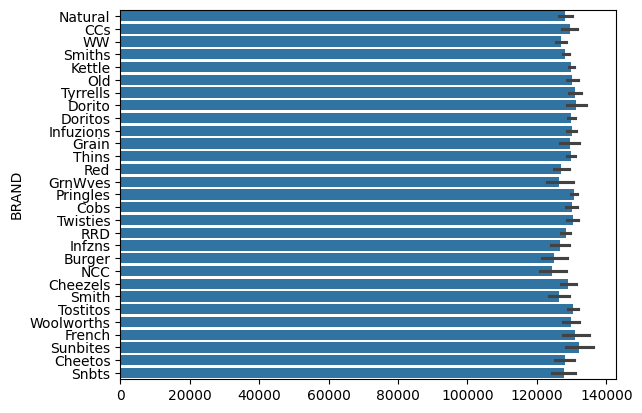

In [35]:
#WHich brands do customers buy most?
sns.barplot(df['BRAND'])

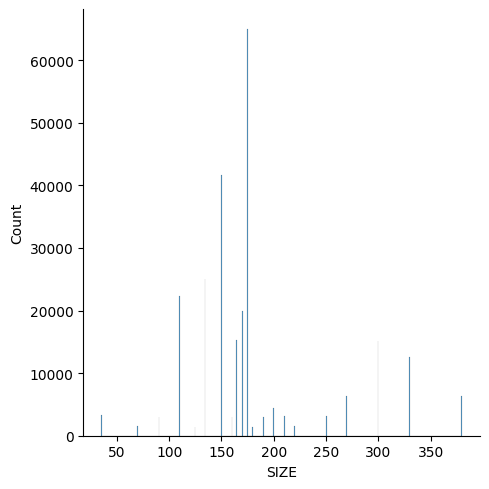

In [36]:
#Which sizes of chips do most people by
sns.displot(df['SIZE'])

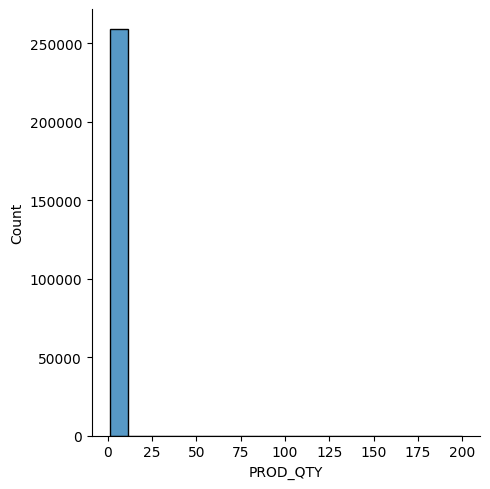

In [37]:
#How many chips do customers buy at once
sns.displot(df['PROD_QTY'])

In [38]:
df.describe()

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_QTY,TOT_SALES,SIZE
count,258770,258770.00,258770.00,258770.00,258770.00,258770.00,258770.00,258770.00
mean,2018-12-30 01:49:57.611778816,135.11,135591.72,135195.47,56.80,1.91,7.33,181.07
min,2018-07-01 00:00:00,1.00,1000.00,1.00,1.00,1.00,1.50,35.00
25%,2018-09-30 00:00:00,70.00,70024.00,67623.25,28.00,2.00,5.40,150.00
50%,2018-12-30 00:00:00,130.00,130378.00,135231.50,57.00,2.00,7.40,170.00
75%,2019-03-31 00:00:00,203.00,203109.50,202753.75,86.00,2.00,9.20,175.00
max,2019-06-30 00:00:00,272.00,2373711.00,2415841.00,114.00,200.00,650.00,380.00
std,NaN,76.79,80667.85,78138.02,33.17,0.52,2.84,66.80


In [39]:
df[df['PROD_QTY']>10]

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,BRAND,PRODUCT,SIZE,LIFESTAGE,PREMIUM_CUSTOMER
69702,2019-05-20,226,226000,226210,4,Dorito Corn Chp Supreme 380g,200,650.00,Dorito,Corn Chp Supreme,380.00,OLDER FAMILIES,Premium


In [40]:
df = df.drop([69702],axis=0)

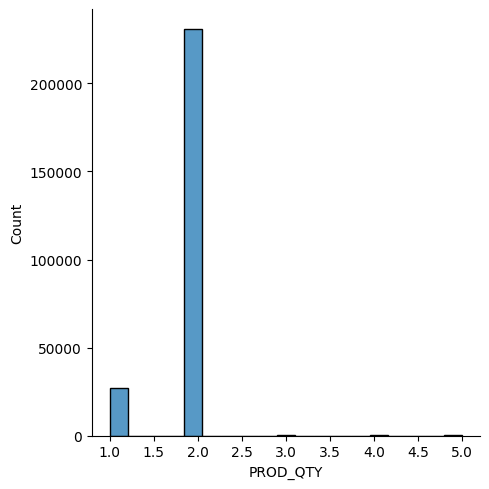

In [41]:
sns.displot(df['PROD_QTY'])

<Axes: ylabel='LIFESTAGE'>

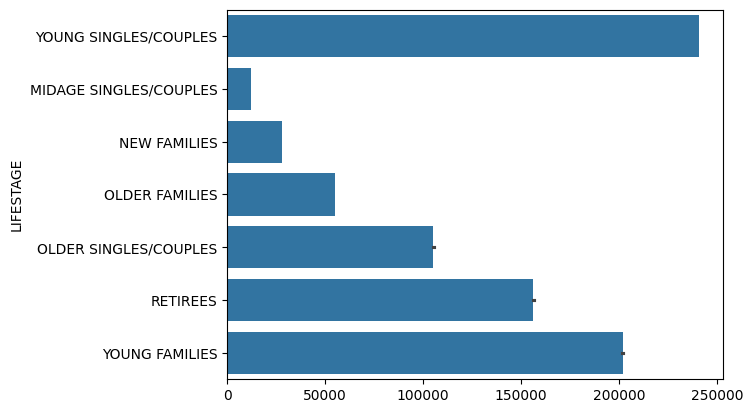

In [42]:
sns.barplot(df['LIFESTAGE'])

<Axes: ylabel='PREMIUM_CUSTOMER'>

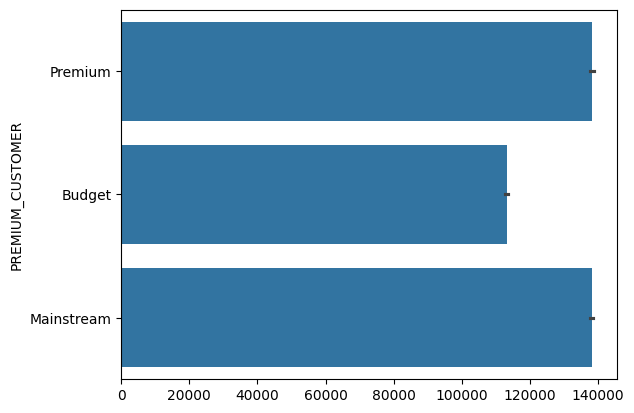

In [43]:
sns.barplot(df['PREMIUM_CUSTOMER'])

<Axes: ylabel='LIFESTAGE'>

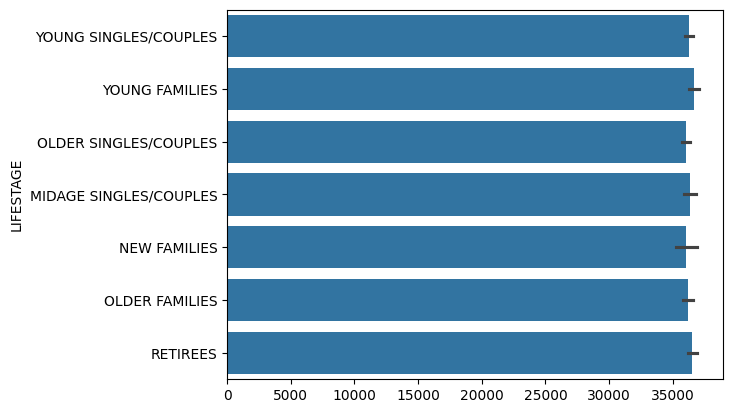

In [44]:
sns.barplot(purchase_behaviour_data['LIFESTAGE'])

<Axes: ylabel='PREMIUM_CUSTOMER'>

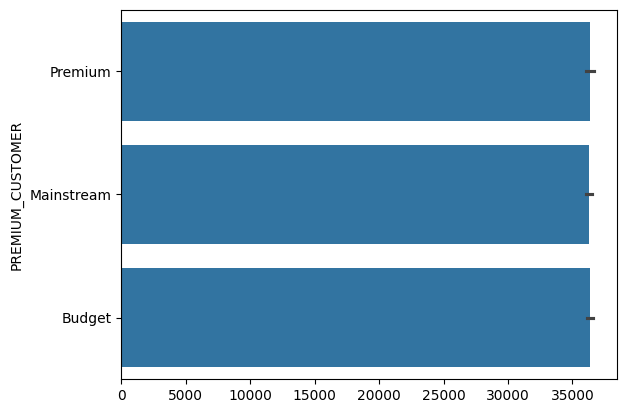

In [45]:
sns.barplot(purchase_behaviour_data['PREMIUM_CUSTOMER'])

In [46]:
df['PROD_NBR'].nunique()

111

### Bivariate relationships

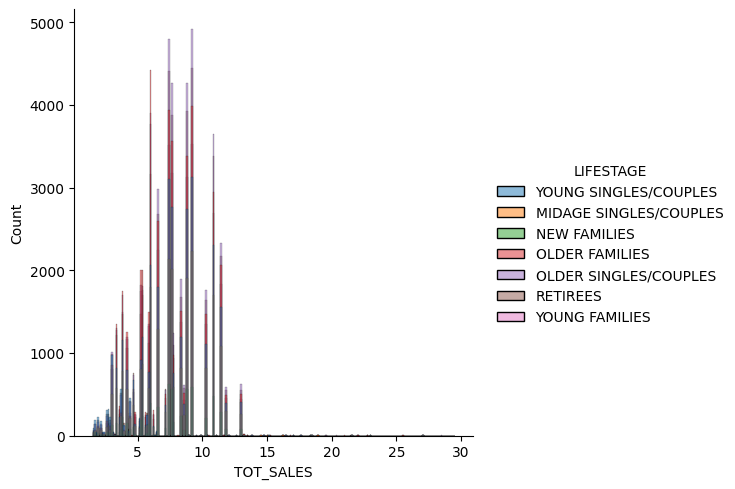

In [47]:
#Highest purchases came from which customers

sns.displot(data=df, x='TOT_SALES', hue='LIFESTAGE')


<function matplotlib.pyplot.show(close=None, block=None)>

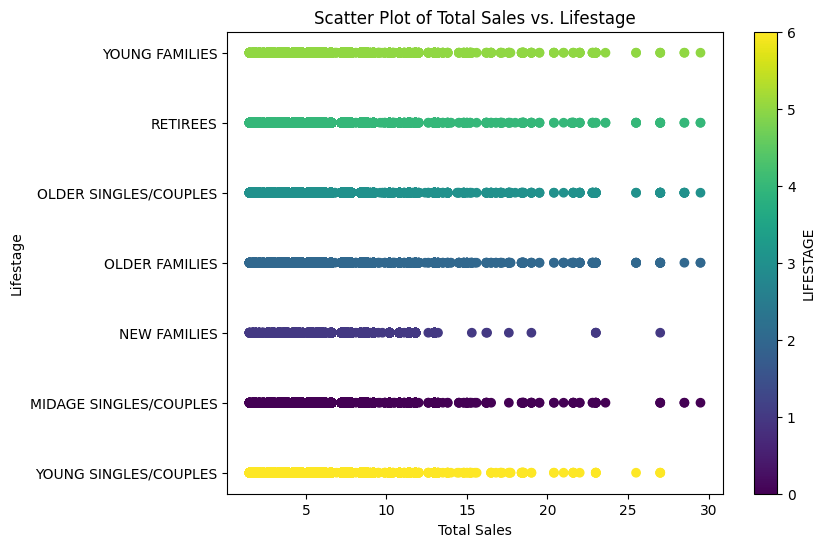

In [48]:
plt.figure(figsize=(8, 6))
scatter = plt.scatter(df['TOT_SALES'], df['LIFESTAGE'], c=df['LIFESTAGE'].astype('category').cat.codes, cmap='viridis')

# Add a color bar to indicate the 'LIFESTAGE' categories
plt.colorbar(scatter, label='LIFESTAGE')

# Label the axes
plt.xlabel('Total Sales')
plt.ylabel('Lifestage')

# Title
plt.title('Scatter Plot of Total Sales vs. Lifestage')

plt.show

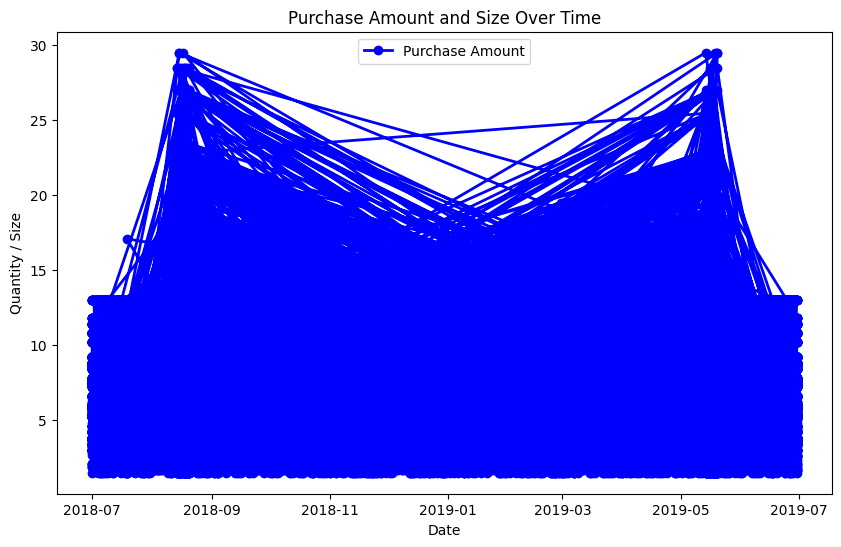

In [49]:
plt.figure(figsize=(10, 6))

# Plot prod_qty
plt.plot(df['DATE'], df['TOT_SALES'], label='Purchase Amount', color='blue', marker='o', linestyle='-', linewidth=2 )

# Plot size
#plt.plot(df['DATE'], df['SIZE'], label='Size', color='green', marker='x')

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Quantity / Size')
plt.title('Purchase Amount and Size Over Time')

# Rotate date labels for better readability
#plt.xticks(rotation=45)

# Add a legend
plt.legend()

# Show the plot
#plt.tight_layout()
plt.show()

In [50]:
# Visusalisations completed in Power BI

In [51]:
#To see the relationship between lifestage and premium customer
from scipy.stats import chi2_contingency


# Create a contingency table
contingency_table = pd.crosstab(df['LIFESTAGE'], df['PREMIUM_CUSTOMER'])

# Perform the Chi-Square test
chi2, p, dof, expected = chi2_contingency(contingency_table)

print("Chi-Square Statistic:", chi2)
print("p-value:", p)

# Interpretation
if p < 0.05:
    print("There is a significant association between the variables.")
else:
    print("There is no significant association between the variables.")


Chi-Square Statistic: 14945.838416598097
p-value: 0.0
There is a significant association between the variables.


In [52]:
contingency_table

PREMIUM_CUSTOMER,Budget,Mainstream,Premium
LIFESTAGE,,,
MIDAGE SINGLES/COUPLES,4921,11599,8029
NEW FAMILIES,2945,2278,1553
OLDER FAMILIES,22590,13870,10936
OLDER SINGLES/COUPLES,18008,17888,17337
RETIREES,14865,21002,12806
YOUNG FAMILIES,18685,12603,11295
YOUNG SINGLES/COUPLES,8995,20434,6130


In [53]:
contingency_table_percent = (contingency_table[contingency_table.columns]/len(df))*100

In [54]:
contingency_table_percent

PREMIUM_CUSTOMER,Budget,Mainstream,Premium
LIFESTAGE,,,
MIDAGE SINGLES/COUPLES,1.90,4.48,3.10
NEW FAMILIES,1.14,0.88,0.60
OLDER FAMILIES,8.73,5.36,4.23
OLDER SINGLES/COUPLES,6.96,6.91,6.70
RETIREES,5.74,8.12,4.95
YOUNG FAMILIES,7.22,4.87,4.36
YOUNG SINGLES/COUPLES,3.48,7.90,2.37


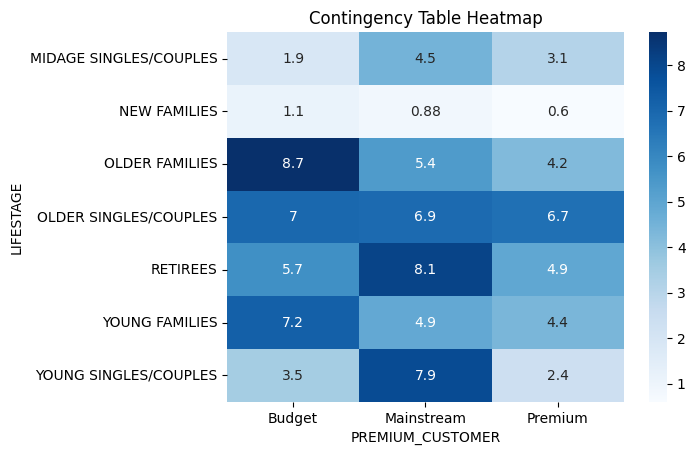

In [55]:
#To see the strength of the relationship
sns.heatmap(contingency_table_percent, annot=True, cmap='Blues')
plt.title("Contingency Table Heatmap")
plt.show()

In [56]:
#Most purchases came from Budget - Older Families, Mainstream Retirees and Main Strean Young and Single couples

In [57]:
contingency_table_sales = pd.pivot_table(
    df,
    values='TOT_SALES',  # The column to aggregate (sum)
    index='LIFESTAGE',   # Rows
    columns='PREMIUM_CUSTOMER',  # Columns
    aggfunc='sum',       # Aggregation function
    fill_value=0)

contingency_table_sales = (contingency_table_sales[contingency_table_sales.columns]/sum(df['TOT_SALES']))*100
contingency_table_sales

PREMIUM_CUSTOMER,Budget,Mainstream,Premium
LIFESTAGE,,,
MIDAGE SINGLES/COUPLES,1.84,4.70,3.02
NEW FAMILIES,1.14,0.88,0.59
OLDER FAMILIES,8.70,5.33,4.17
OLDER SINGLES/COUPLES,7.08,6.90,6.84
RETIREES,5.86,8.06,5.06
YOUNG FAMILIES,7.21,4.79,4.35
YOUNG SINGLES/COUPLES,3.15,8.18,2.15


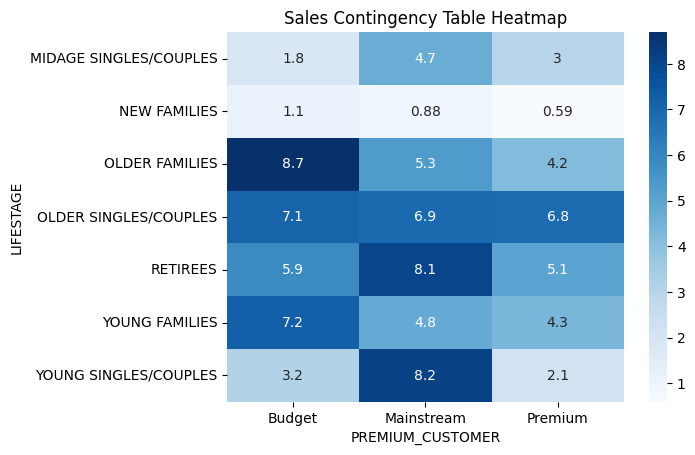

In [58]:
#To see the strength of the relationship
sns.heatmap(contingency_table_sales, annot=True, cmap='Blues')
plt.title("Sales Contingency Table Heatmap")
plt.show()

In [59]:
#WHich type of customers buy what
contingency_table2 = pd.crosstab(df['BRAND'], df['PREMIUM_CUSTOMER'])
contingency_table2

PREMIUM_CUSTOMER,Budget,Mainstream,Premium
BRAND,,,
Burger,579,548,437
CCs,1679,1631,1241
Cheetos,1051,1111,765
Cheezels,1626,1735,1242
Cobs,3274,3889,2530
Dorito,1056,1253,874
Doritos,8762,9939,6261
French,539,507,372
Grain,1067,1293,807


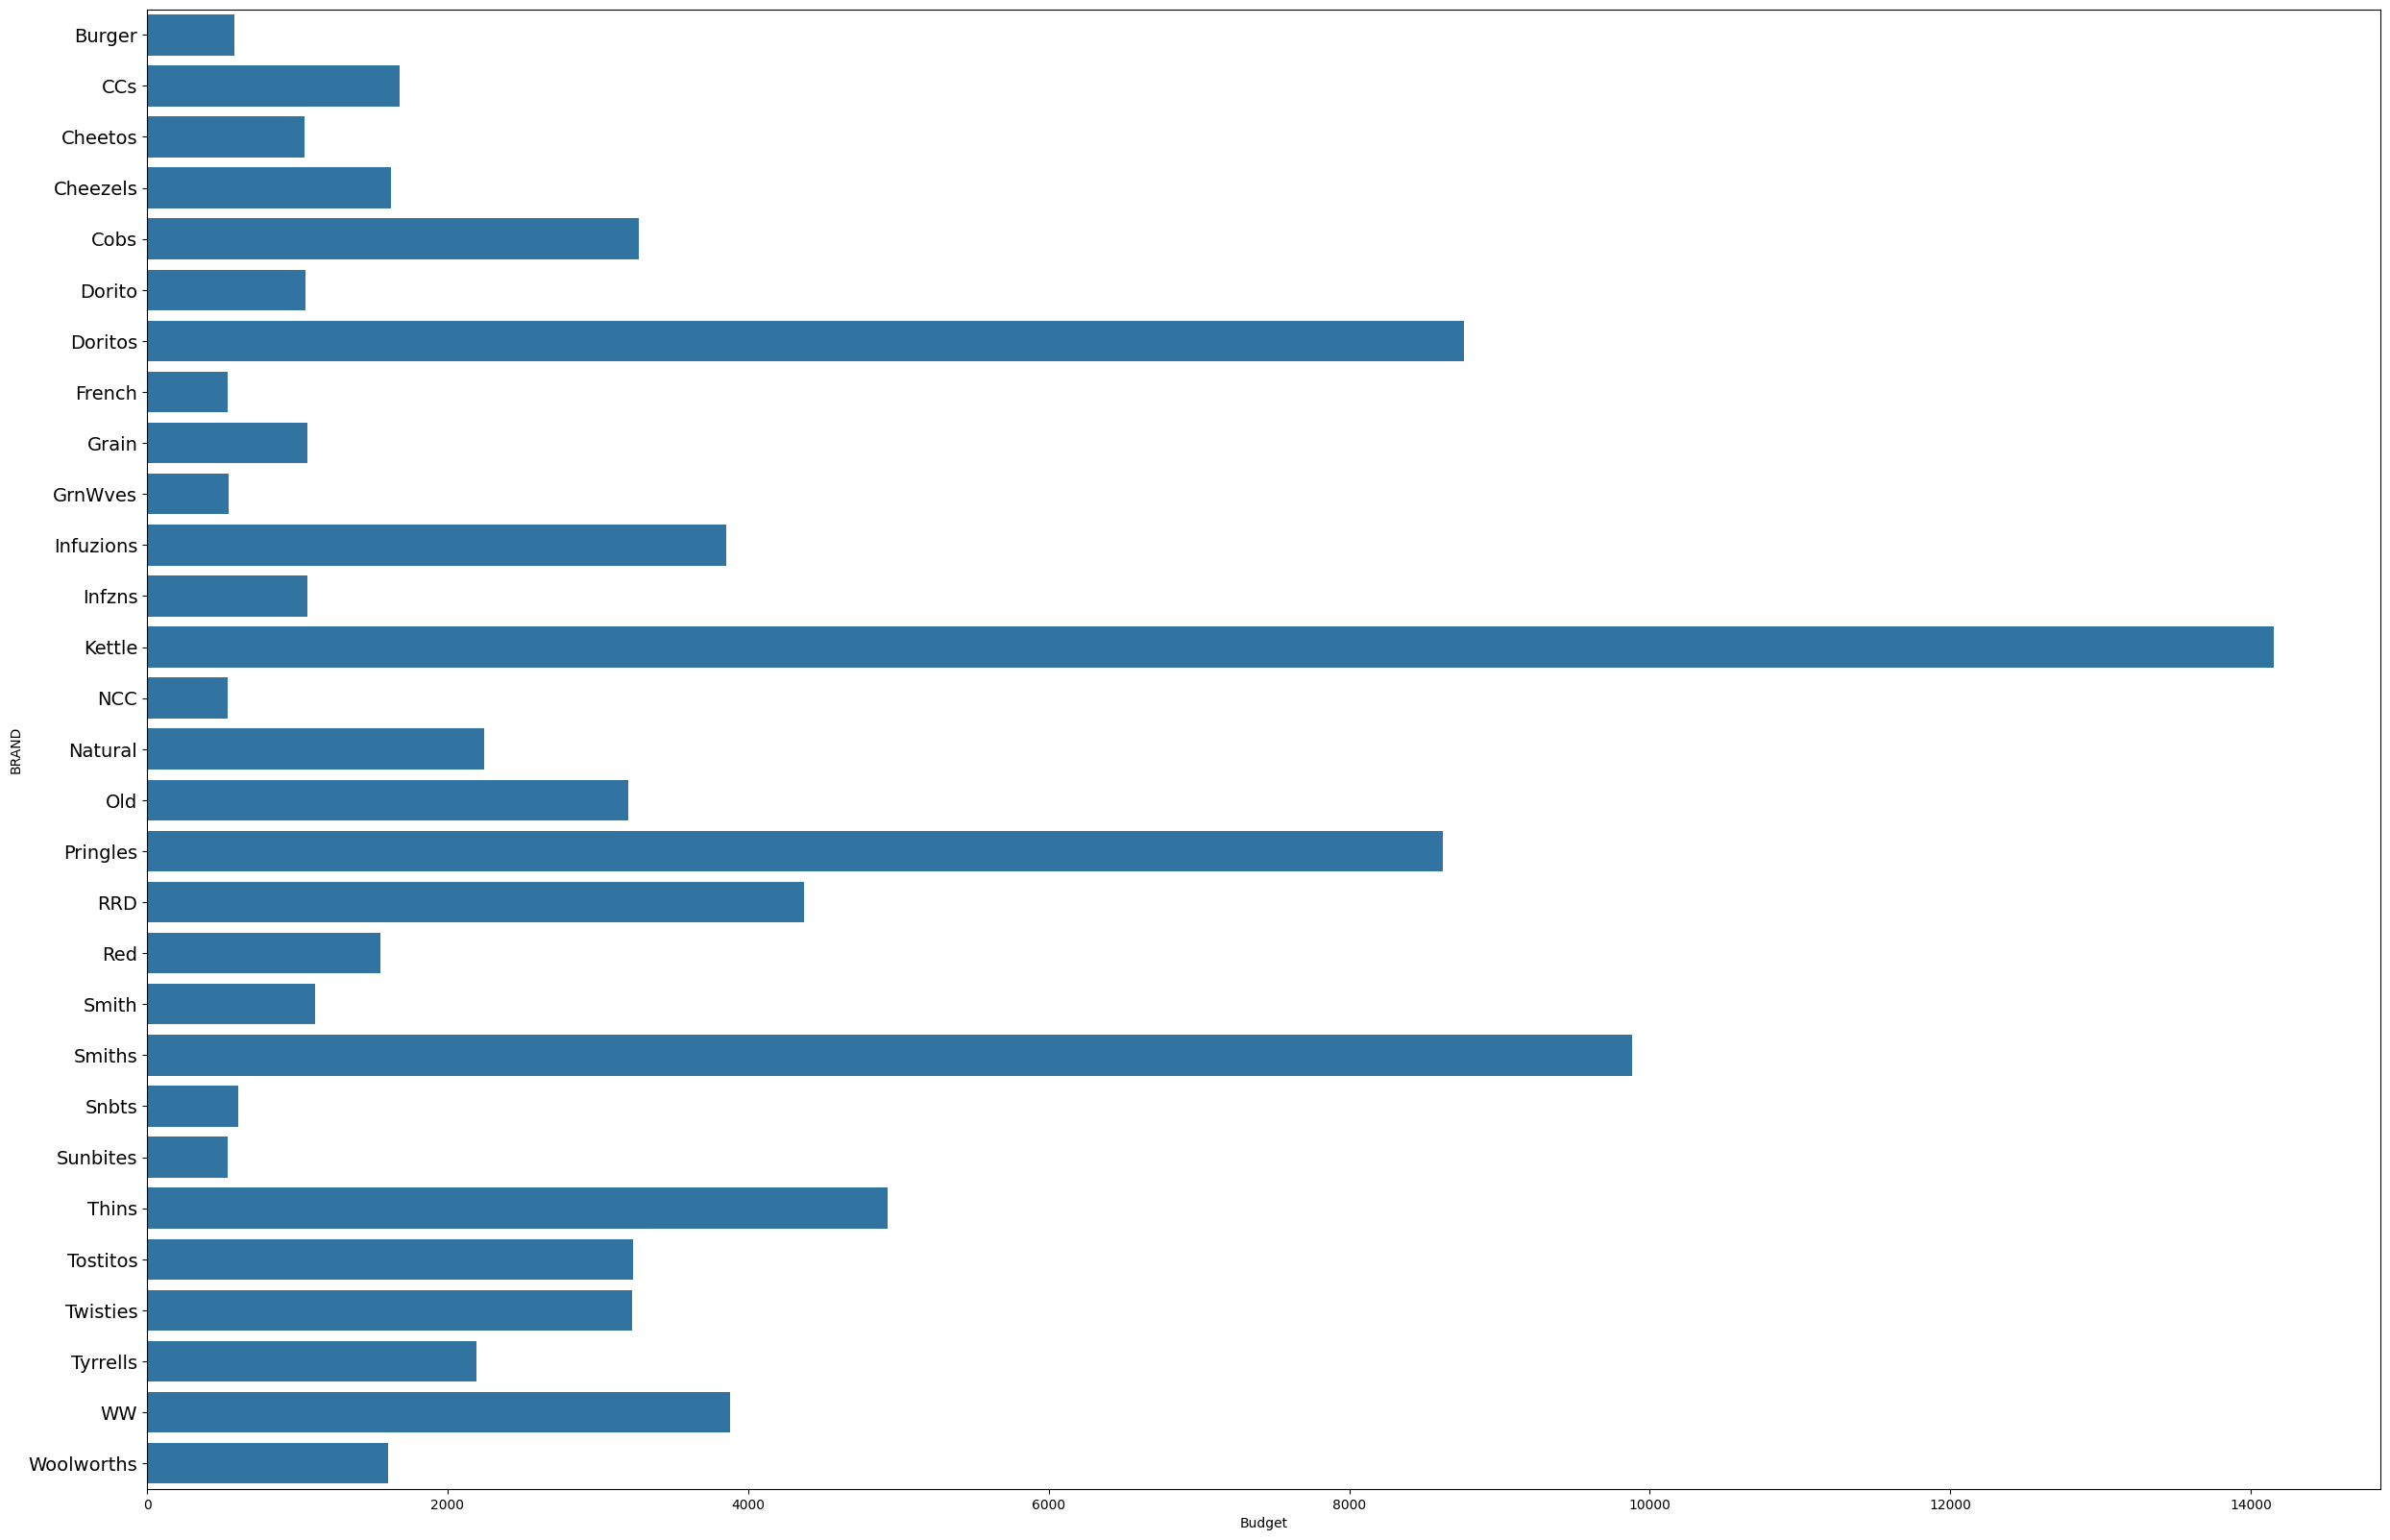

In [60]:
plt.figure(figsize=(30,20))
sns.barplot(contingency_table2['Budget'], orient='h')
plt.yticks(fontsize=14)
plt.show()

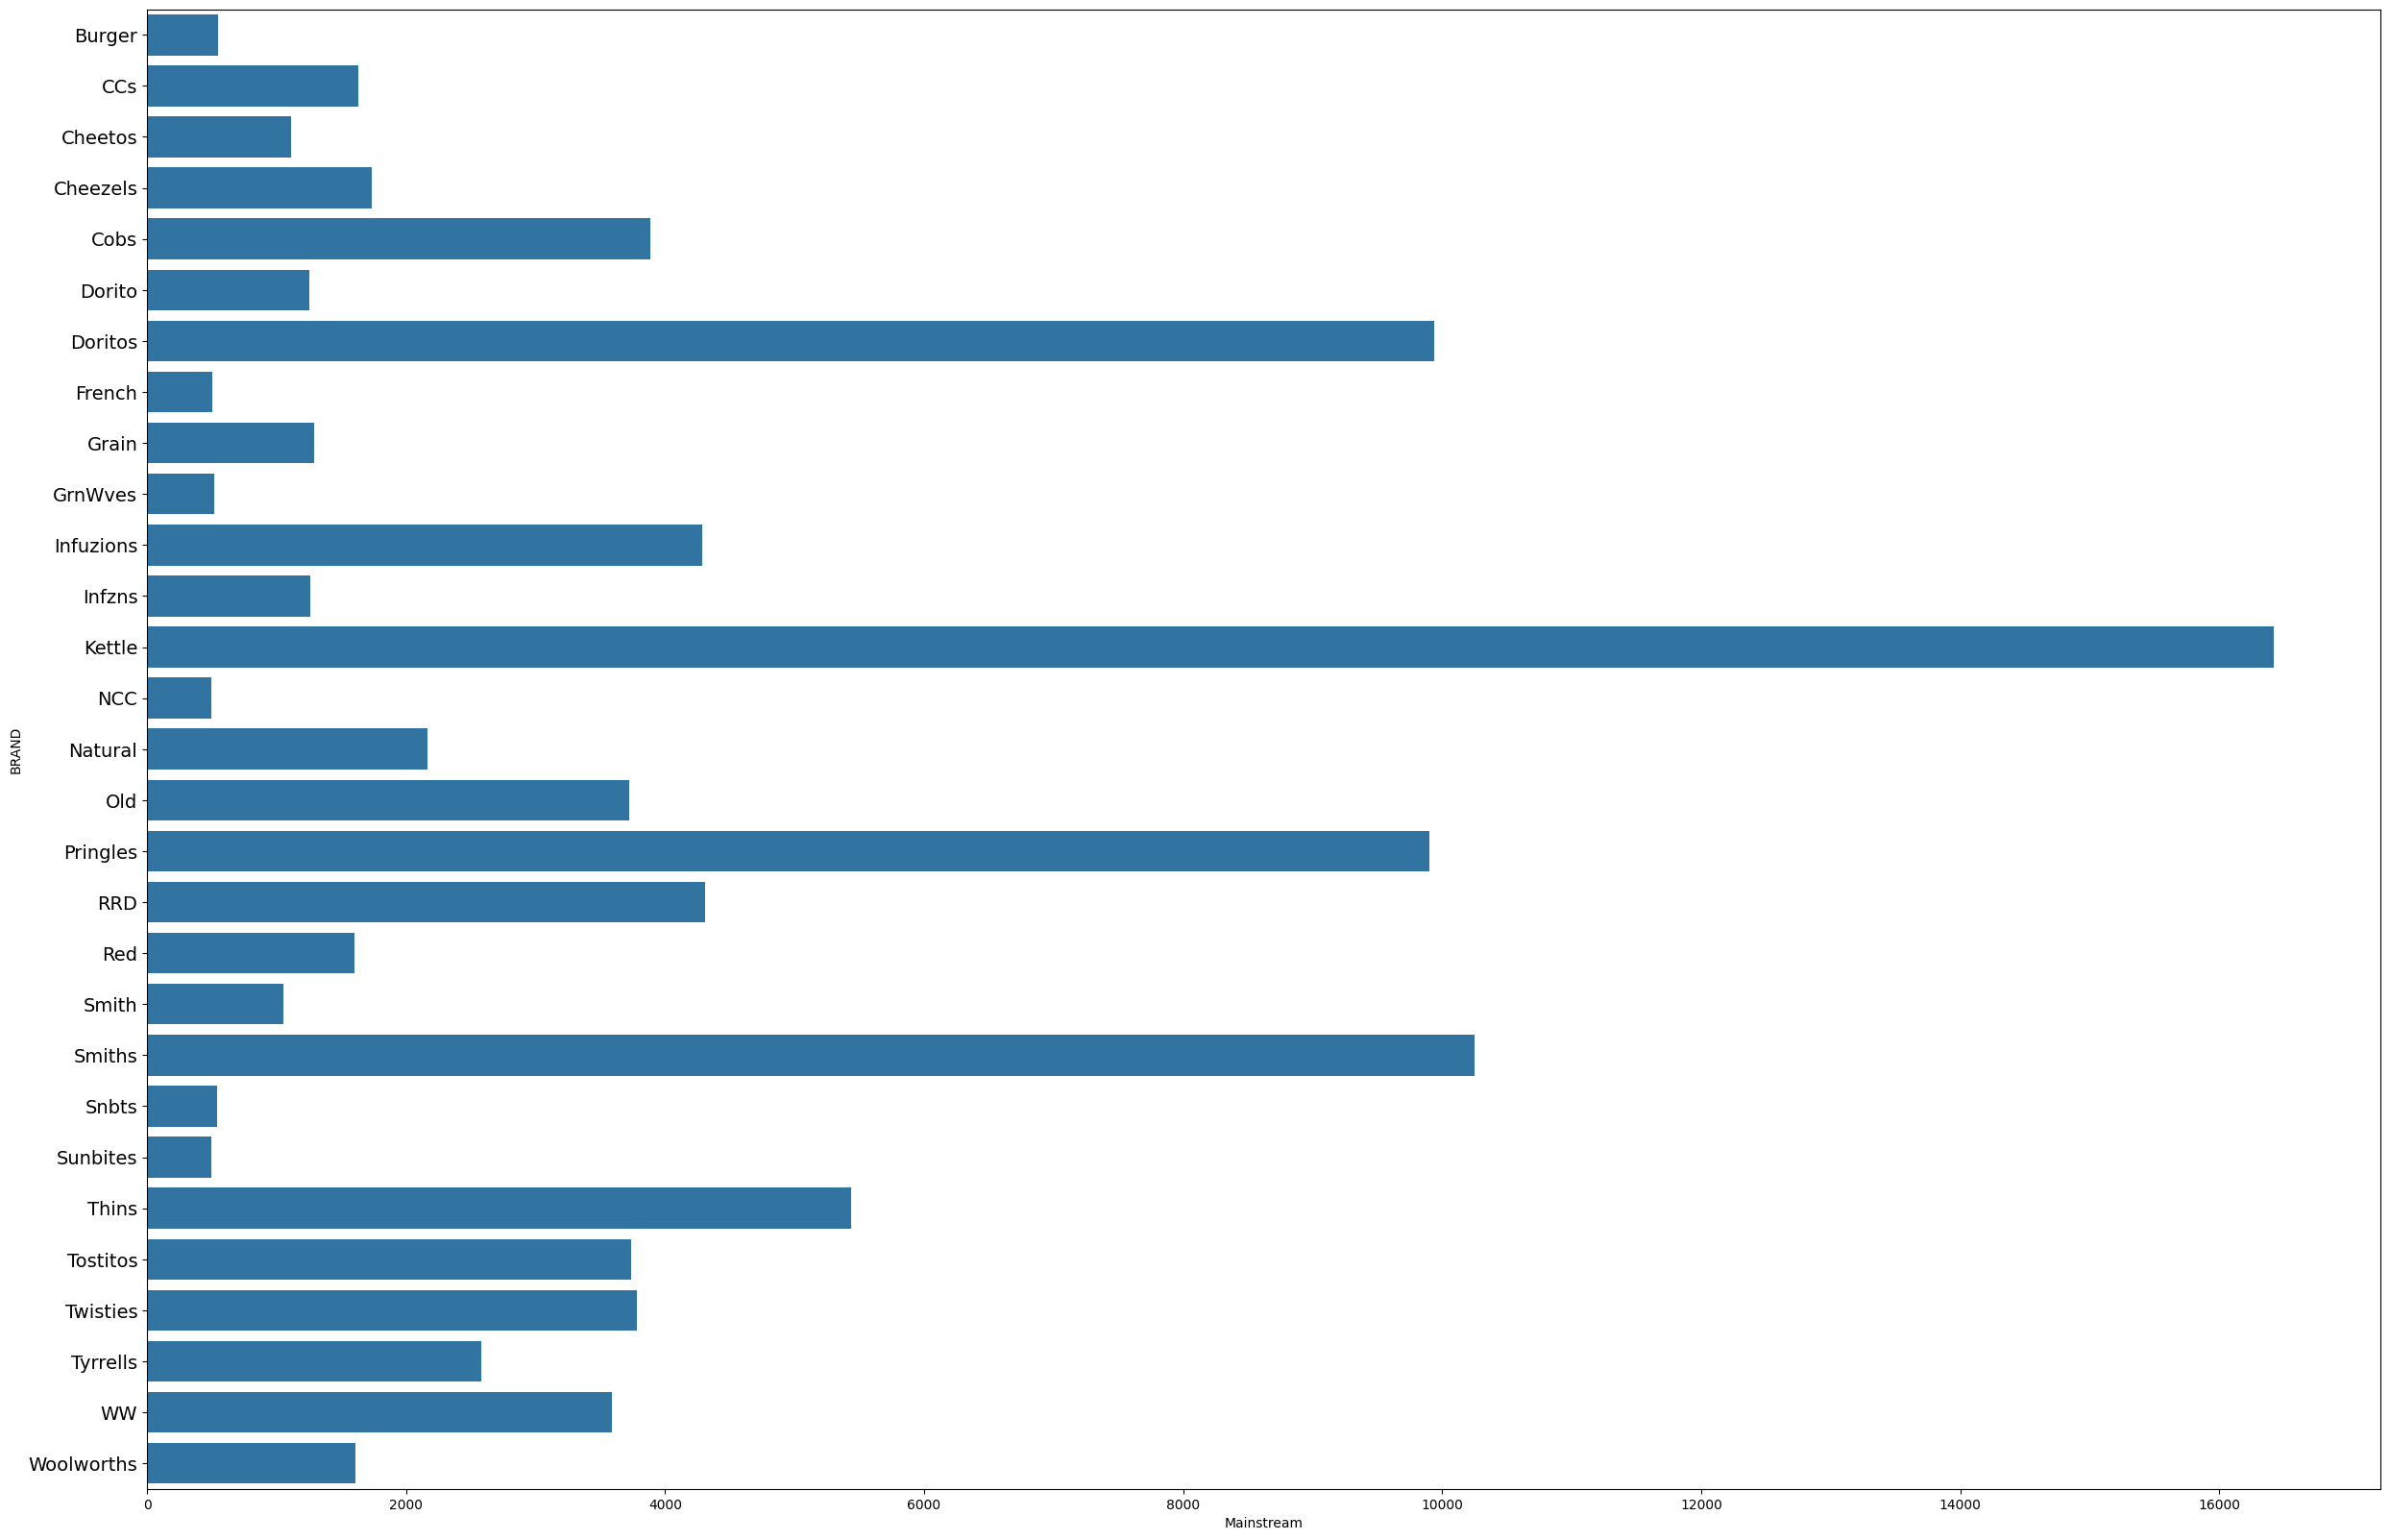

In [61]:
plt.figure(figsize=(30,20))
sns.barplot(contingency_table2['Mainstream'], orient='h')
plt.yticks(fontsize=14)
plt.show()

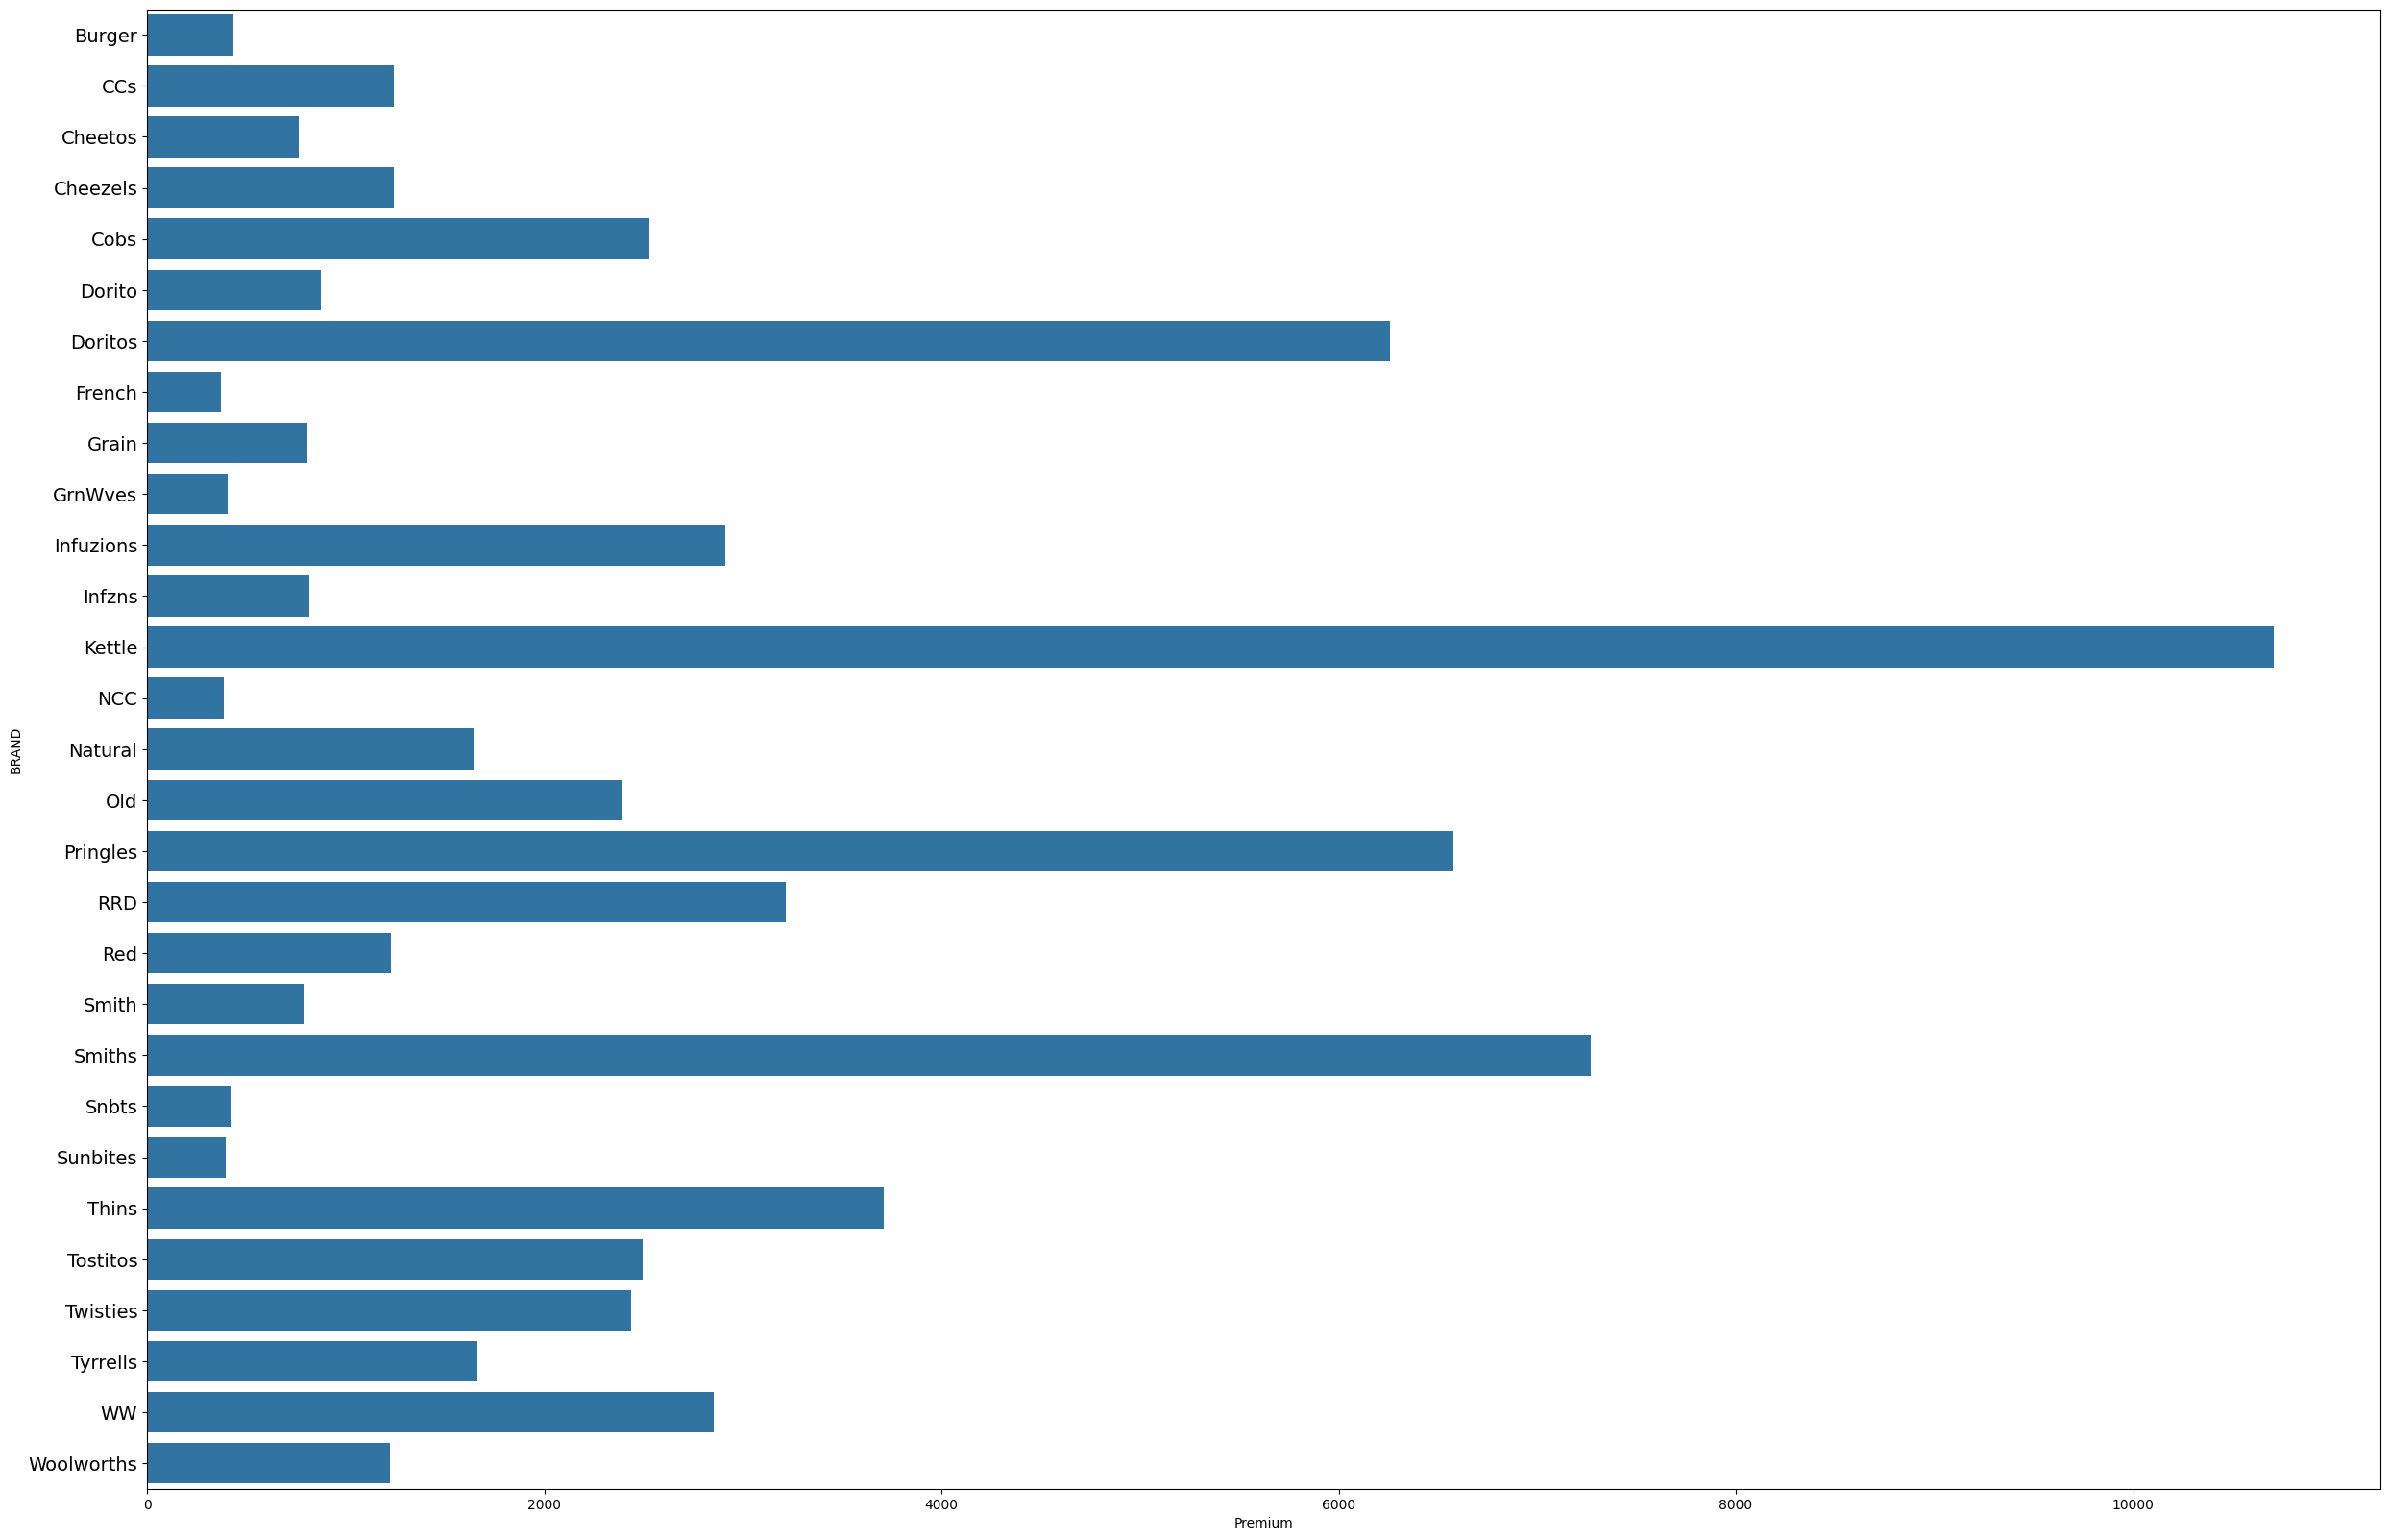

In [62]:
plt.figure(figsize=(30,20))
sns.barplot(contingency_table2['Premium'], orient='h')
plt.yticks(fontsize=14)
plt.show()

In [63]:
# Let's see if pricing affects the purchase
df['Price'] = df['TOT_SALES']/df['PROD_QTY']
df['Price_per_100g'] = (df['Price']*100)/df['SIZE']
df.head()

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,BRAND,PRODUCT,SIZE,LIFESTAGE,PREMIUM_CUSTOMER,Price,Price_per_100g
0,2018-10-17,1,1000,1,5,Natural Chip Compny SeaSalt175g,2,6.00,Natural,Chip Compny SeaSalt,175.00,YOUNG SINGLES/COUPLES,Premium,3.00,1.71
1,2019-05-14,1,1307,348,66,CCs Nacho Cheese 175g,3,6.30,CCs,Nacho Cheese,175.00,MIDAGE SINGLES/COUPLES,Budget,2.10,1.20
2,2018-11-10,1,1307,346,96,WW Original Stacked Chips 160g,2,3.80,WW,Original Stacked Chips,160.00,MIDAGE SINGLES/COUPLES,Budget,1.90,1.19
3,2019-03-09,1,1307,347,54,CCs Original 175g,1,2.10,CCs,Original,175.00,MIDAGE SINGLES/COUPLES,Budget,2.10,1.20
4,2019-05-20,1,1343,383,61,Smiths Crinkle Cut Chips Chicken 170g,2,2.90,Smiths,Crinkle Cut Chips Chicken,170.00,MIDAGE SINGLES/COUPLES,Budget,1.45,0.85


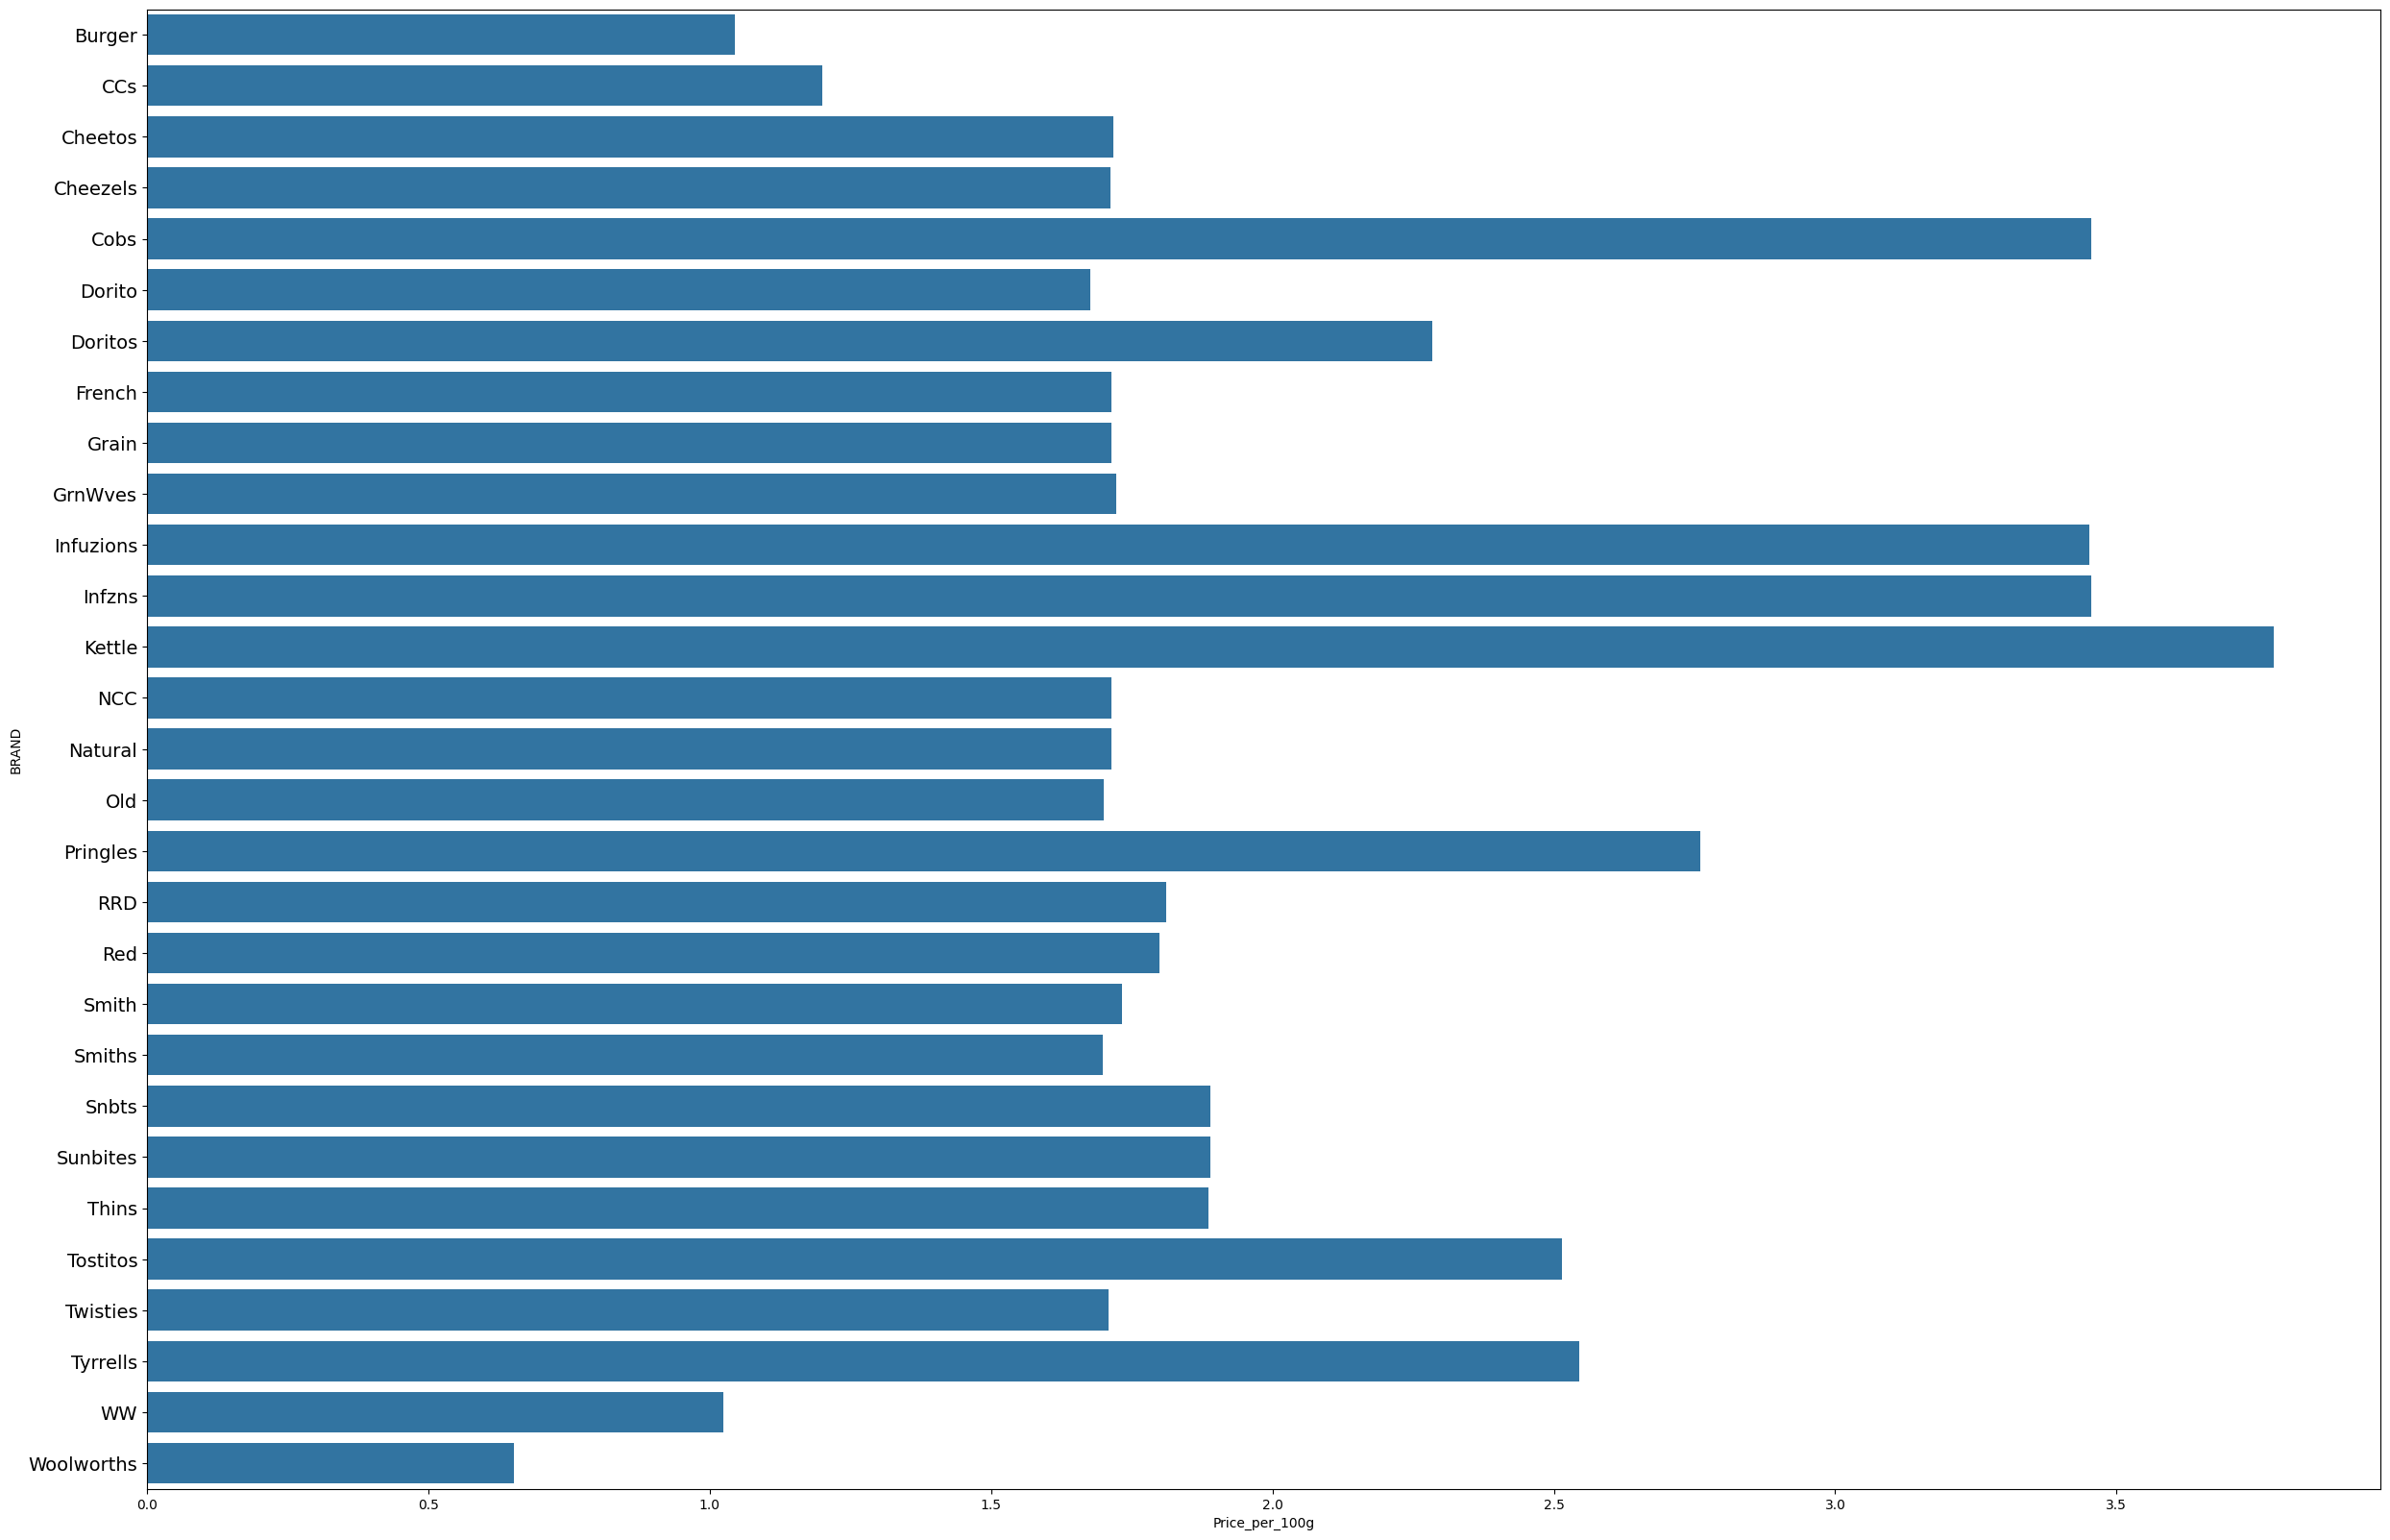

In [64]:
avg_brand_price = df['Price_per_100g'].groupby(df['BRAND']).mean()
plt.figure(figsize=(30,20))
sns.barplot(avg_brand_price, orient='h')
plt.yticks(fontsize=14)
plt.show()

In [65]:
#Kettle seems to be the most expensive

In [66]:
kettle_trans = df[df['BRAND']=='Kettle'] 
kettle_trans['PRODUCT'].nunique()

13

In [67]:
df.columns

Index(['DATE', 'STORE_NBR', 'LYLTY_CARD_NBR', 'TXN_ID', 'PROD_NBR',
       'PROD_NAME', 'PROD_QTY', 'TOT_SALES', 'BRAND', 'PRODUCT', 'SIZE',
       'LIFESTAGE', 'PREMIUM_CUSTOMER', 'Price', 'Price_per_100g'],
      dtype='object')

In [105]:
average_purchases_qty = pd.DataFrame(df.groupby(['LIFESTAGE', 'PREMIUM_CUSTOMER'])['PROD_QTY'].mean())
average_purchases_qty

PROD_QTY
LIFESTAGE              PREMIUM_CUSTOMER          
MIDAGE SINGLES/COUPLES Budget                1.89
                       Mainstream            1.91
                       Premium               1.89
NEW FAMILIES           Budget                1.85
                       Mainstream            1.86
                       Premium               1.86
OLDER FAMILIES         Budget                1.95
                       Mainstream            1.95
                       Premium               1.95
OLDER SINGLES/COUPLES  Budget                1.91
                       Mainstream            1.91
                       Premium               1.91
RETIREES               Budget                1.89
                       Mainstream            1.89
                       Premium               1.90
YOUNG FAMILIES         Budget                1.94
                       Mainstream            1.94
                       Premium               1.94
YOUNG SINGLES/COUPLES  Budget                1.80
                       Mainstream            1.85
                       Premium               1.80

<Axes: xlabel='LIFESTAGE', ylabel='value'>

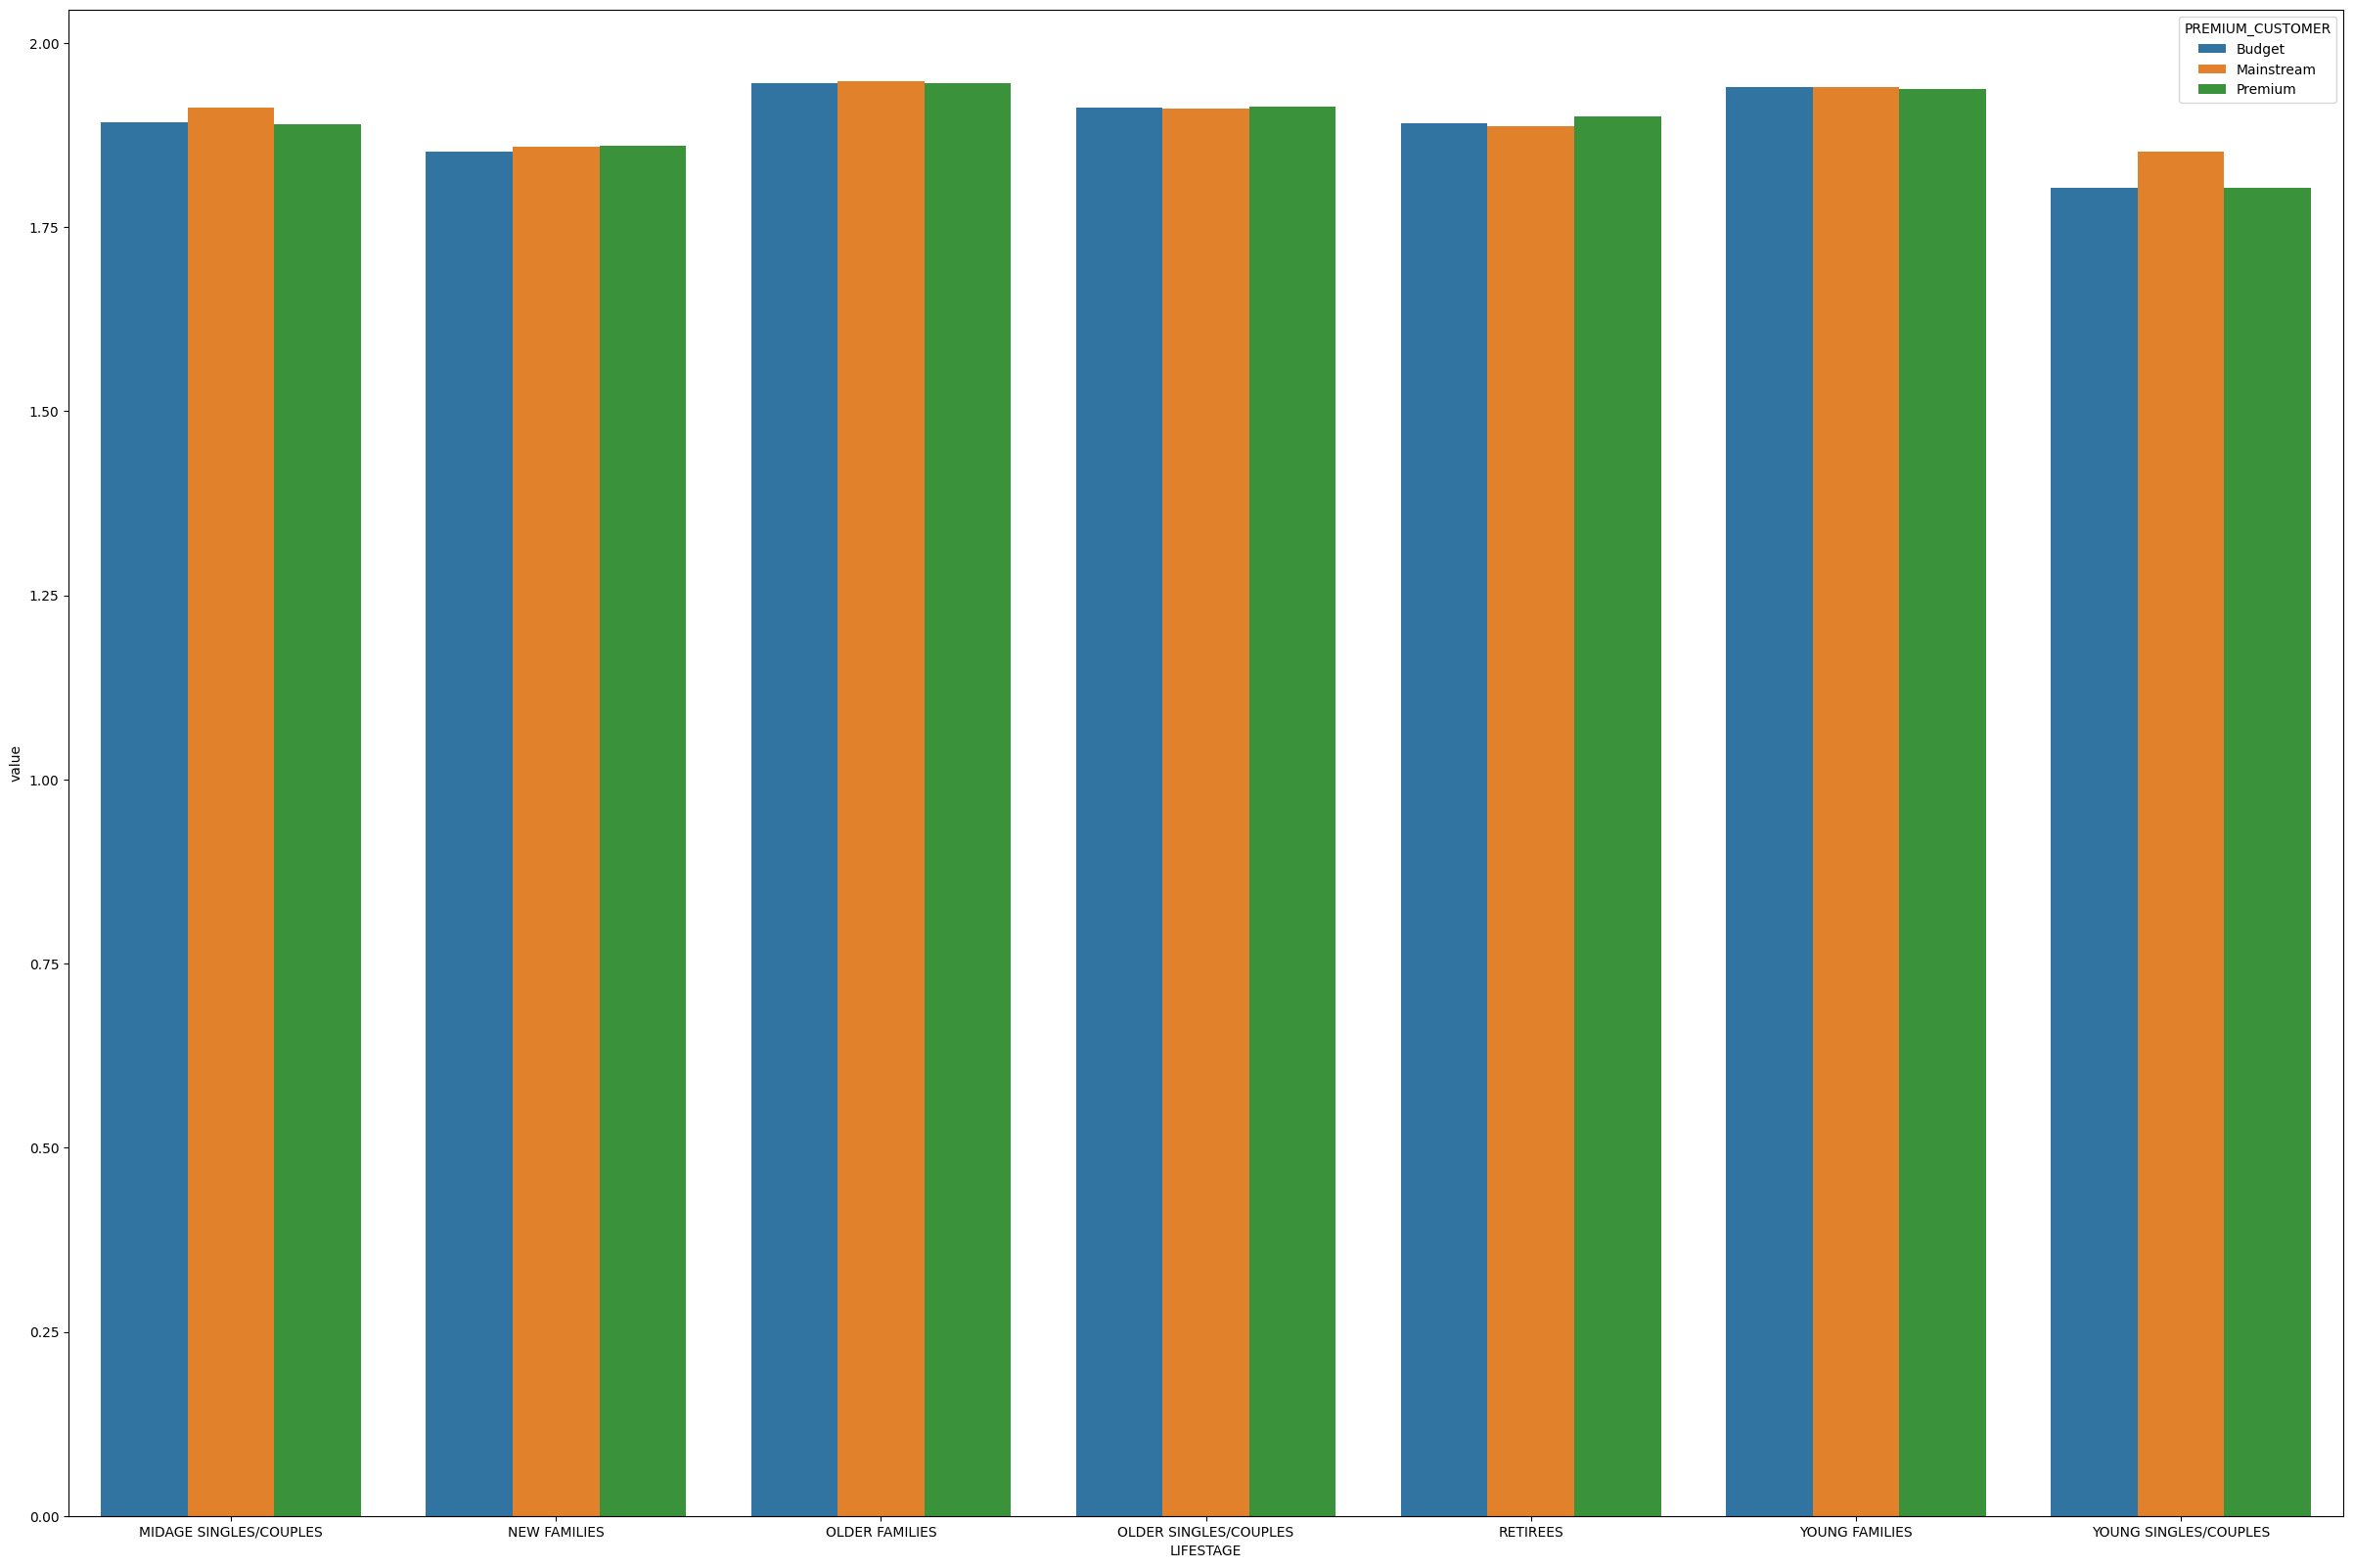

In [106]:
plt.figure(figsize=(30,20))
sns.barplot(data=average_purchases_qty.transpose().melt(), x='LIFESTAGE', y='value' , hue='PREMIUM_CUSTOMER')

In [103]:
#Older families and younger families buy more packs than other groups which is intuitive

In [108]:
average_spend_per_purchase = pd.DataFrame(df.groupby(['LIFESTAGE', 'PREMIUM_CUSTOMER'])['Price'].mean())
average_spend_per_purchase

Price
LIFESTAGE              PREMIUM_CUSTOMER       
MIDAGE SINGLES/COUPLES Budget             3.74
                       Mainstream         4.02
                       Premium            3.76
NEW FAMILIES           Budget             3.93
                       Mainstream         3.93
                       Premium            3.88
OLDER FAMILIES         Budget             3.75
                       Mainstream         3.74
                       Premium            3.72
OLDER SINGLES/COUPLES  Budget             3.89
                       Mainstream         3.82
                       Premium            3.90
RETIREES               Budget             3.94
                       Mainstream         3.85
                       Premium            3.94
YOUNG FAMILIES         Budget             3.77
                       Mainstream         3.72
                       Premium            3.77
YOUNG SINGLES/COUPLES  Budget             3.65
                       Mainstream         4.09
                       Premium            3.66

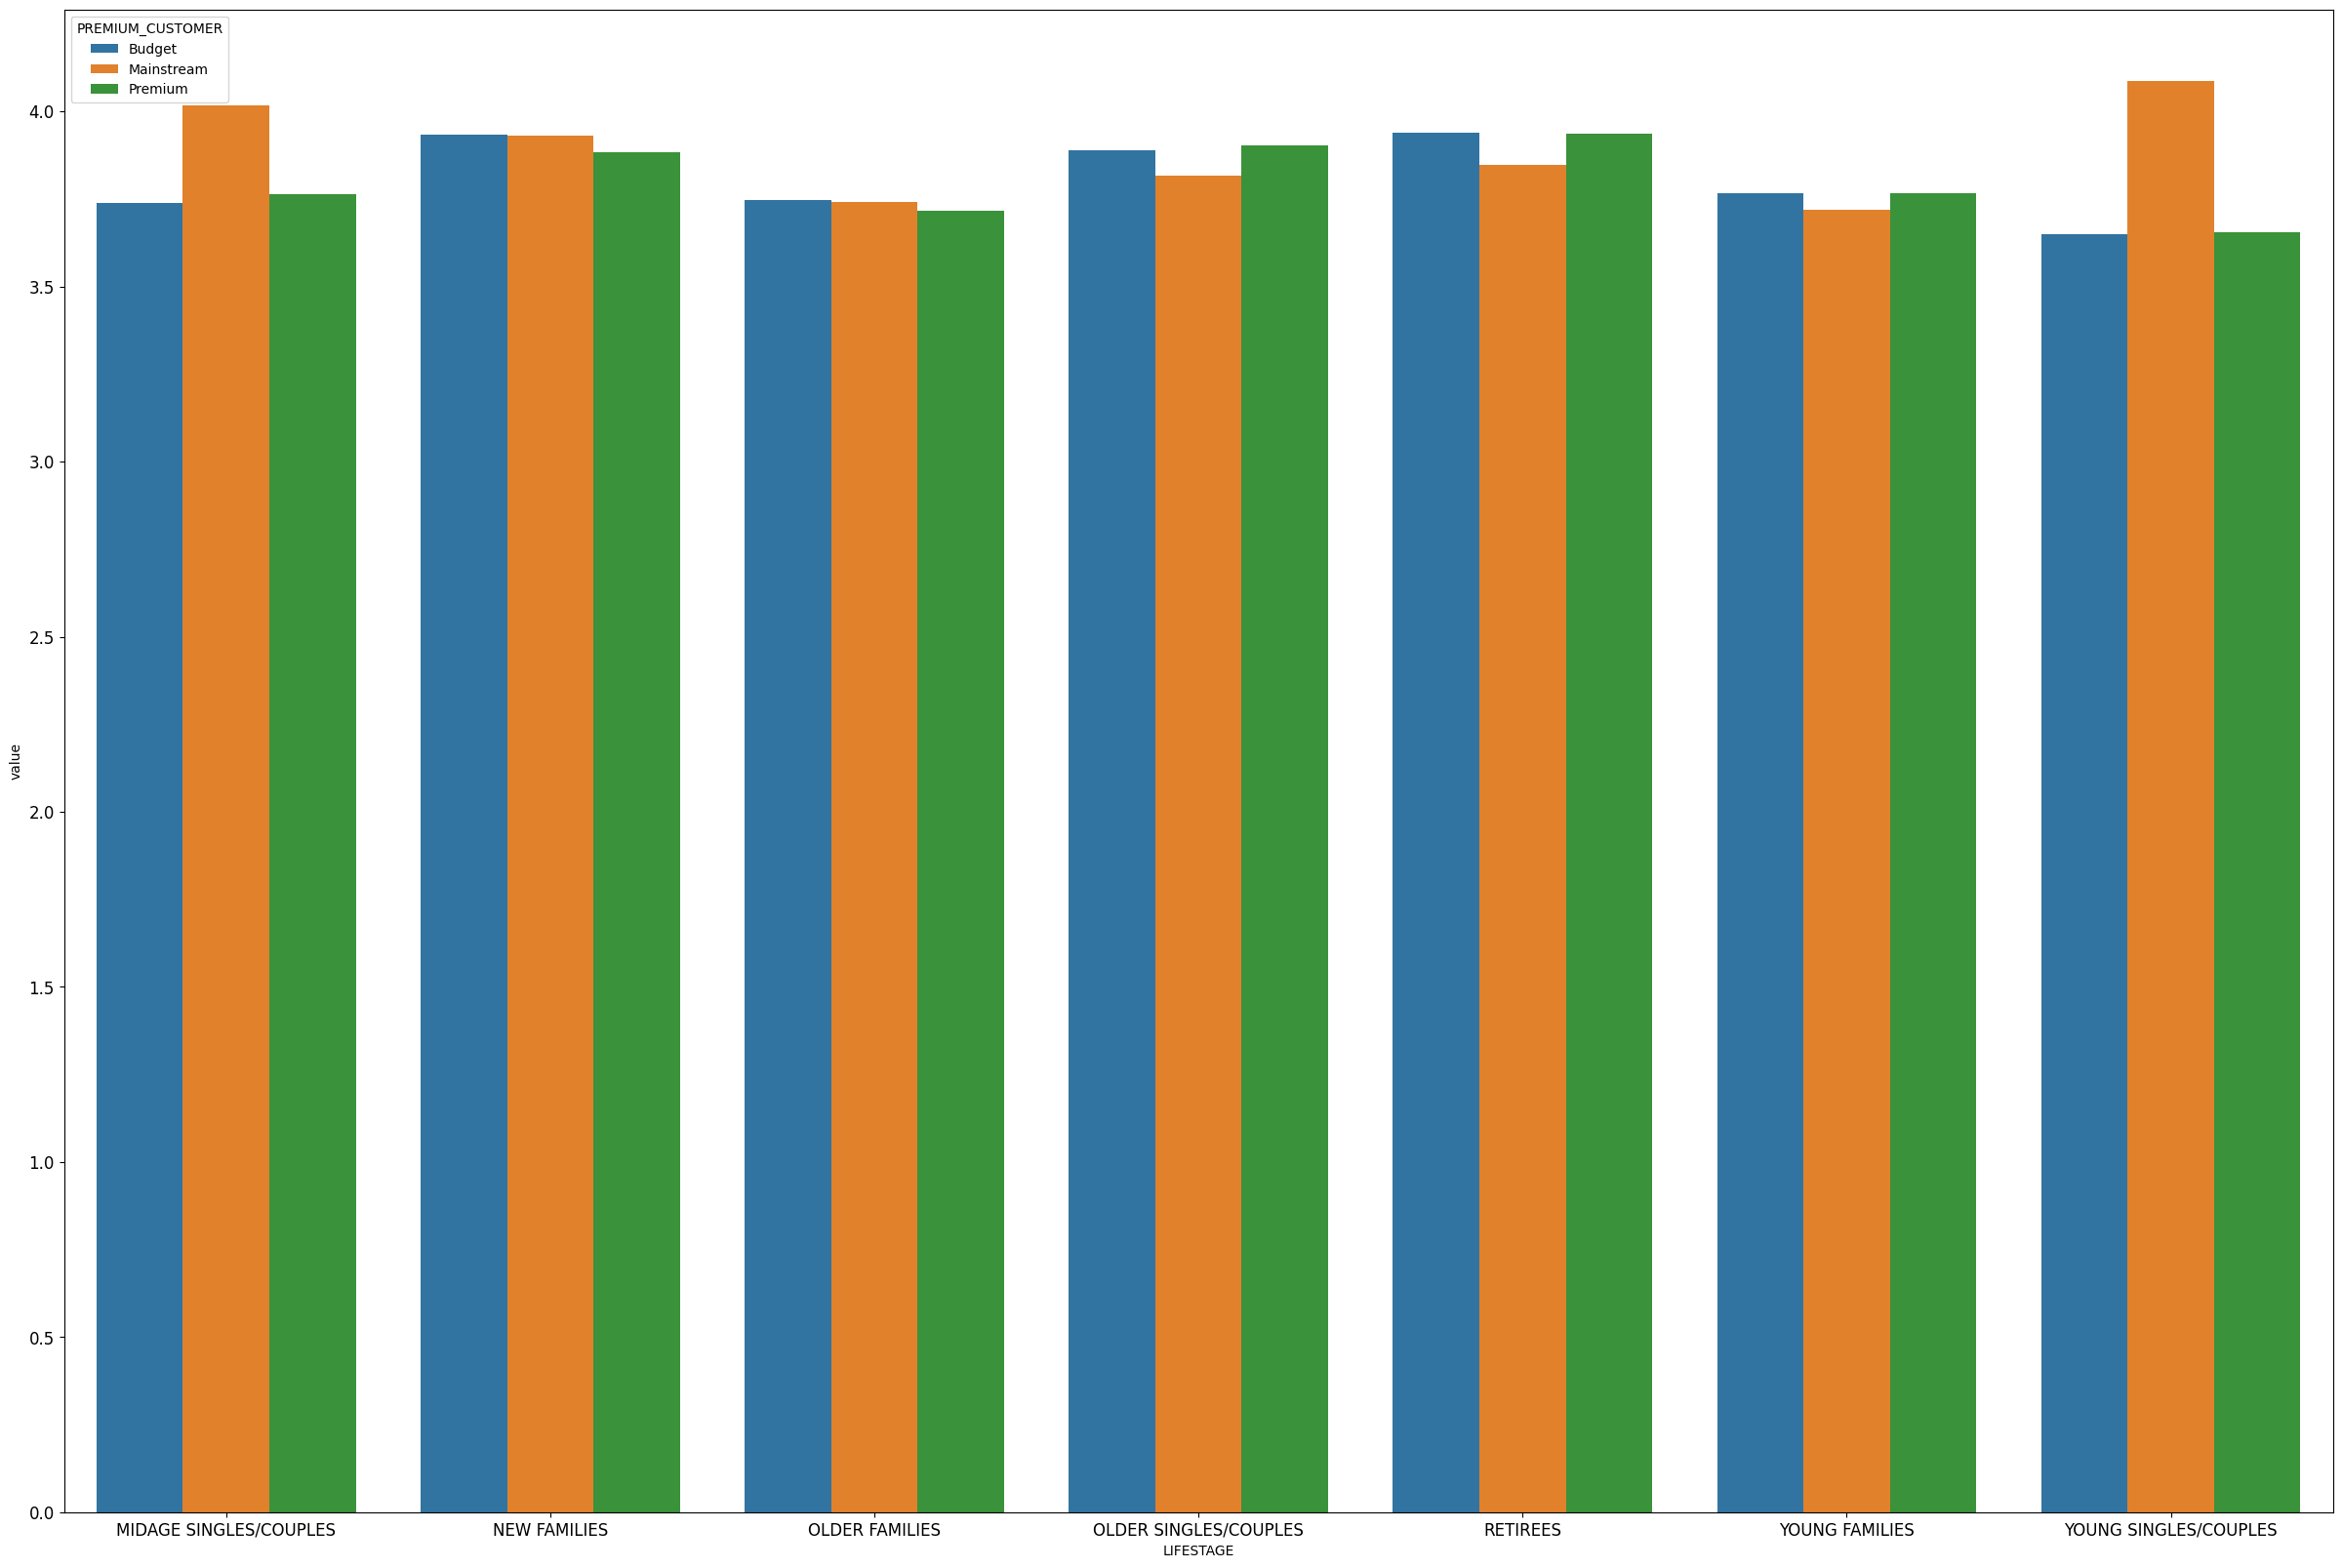

In [113]:
plt.figure(figsize=(30,20))
sns.barplot(data=average_spend_per_purchase.transpose().melt(), x='LIFESTAGE', y='value' , hue='PREMIUM_CUSTOMER')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

 Mainstream midage couples and mainstream yooung couples buy more quality products This may be due to premium shoppers being more likely to
buy healthy snacks and when they buy chips, this is mainly for entertainment purposes rather than their own
consumption. This is also supported by there being fewer premium midage and young singles and couples
buying chips compared to their mainstream counterparts.
As the difference in average price per unit isn’t large, we can check if this difference is statistically different.


In [129]:

data

,LIFESTAGE,PREMIUM_CUSTOMER,Price
0,MIDAGE SINGLES/COUPLES,Budget,3.74
1,MIDAGE SINGLES/COUPLES,Mainstream,4.02
2,MIDAGE SINGLES/COUPLES,Premium,3.76
3,NEW FAMILIES,Budget,3.93
4,NEW FAMILIES,Mainstream,3.93
5,NEW FAMILIES,Premium,3.88
6,OLDER FAMILIES,Budget,3.75
7,OLDER FAMILIES,Mainstream,3.74
8,OLDER FAMILIES,Premium,3.72
9,OLDER SINGLES/COUPLES,Budget,3.89


In [137]:
data = average_spend_per_purchase.transpose().melt()
data.rename(columns={'value':'Price'}, inplace=True)

# Filter by LIFESTAGE
midage_and_YC = data[(data['LIFESTAGE'] == 'MIDAGE SINGLES/COUPLES') | (data['LIFESTAGE'] == 'YOUNG SINGLES/COUPLES')]
mainstream = midage_and_YC[midage_and_YC['PREMIUM_CUSTOMER'] == 'Mainstream']
premium = midage_and_YC[midage_and_YC['PREMIUM_CUSTOMER'] == 'Premium']
budget = midage_and_YC[midage_and_YC['PREMIUM_CUSTOMER'] == 'Budget']






In [138]:
from scipy import stats

# Perform the t-test for Mainstream vs Premium
t_stat1, p_value1 = stats.ttest_ind(mainstream['Price'], premium['Price'])
print("Mainstream vs Premium - T-statistic:", t_stat1, "P-value:", p_value1)

# Perform the t-test for Budget vs Mainstream
t_stat2, p_value2 = stats.ttest_ind(budget['Price'], mainstream['Price'])
print("Budget vs Midage Singles/Couples - T-statistic:", t_stat2, "P-value:", p_value2)




Mainstream vs Premium - T-statistic: 5.273146341852119 P-value: 0.034132732159663504
Budget vs Midage Singles/Couples - T-statistic: -6.403819551634698 P-value: 0.023527777061725316


In [139]:
#There is s statistical significant difference in Mainstream and Premium Budget buyers in these categories 

We have found quite a few interesting insights that we can dive deeper into.
We might want to target customer segments that contribute the most to sales to retain them or further
increase sales. Let’s look at Mainstream - young singles/couples. For instance, let’s find out if they tend to
buy a particular brand of chips.


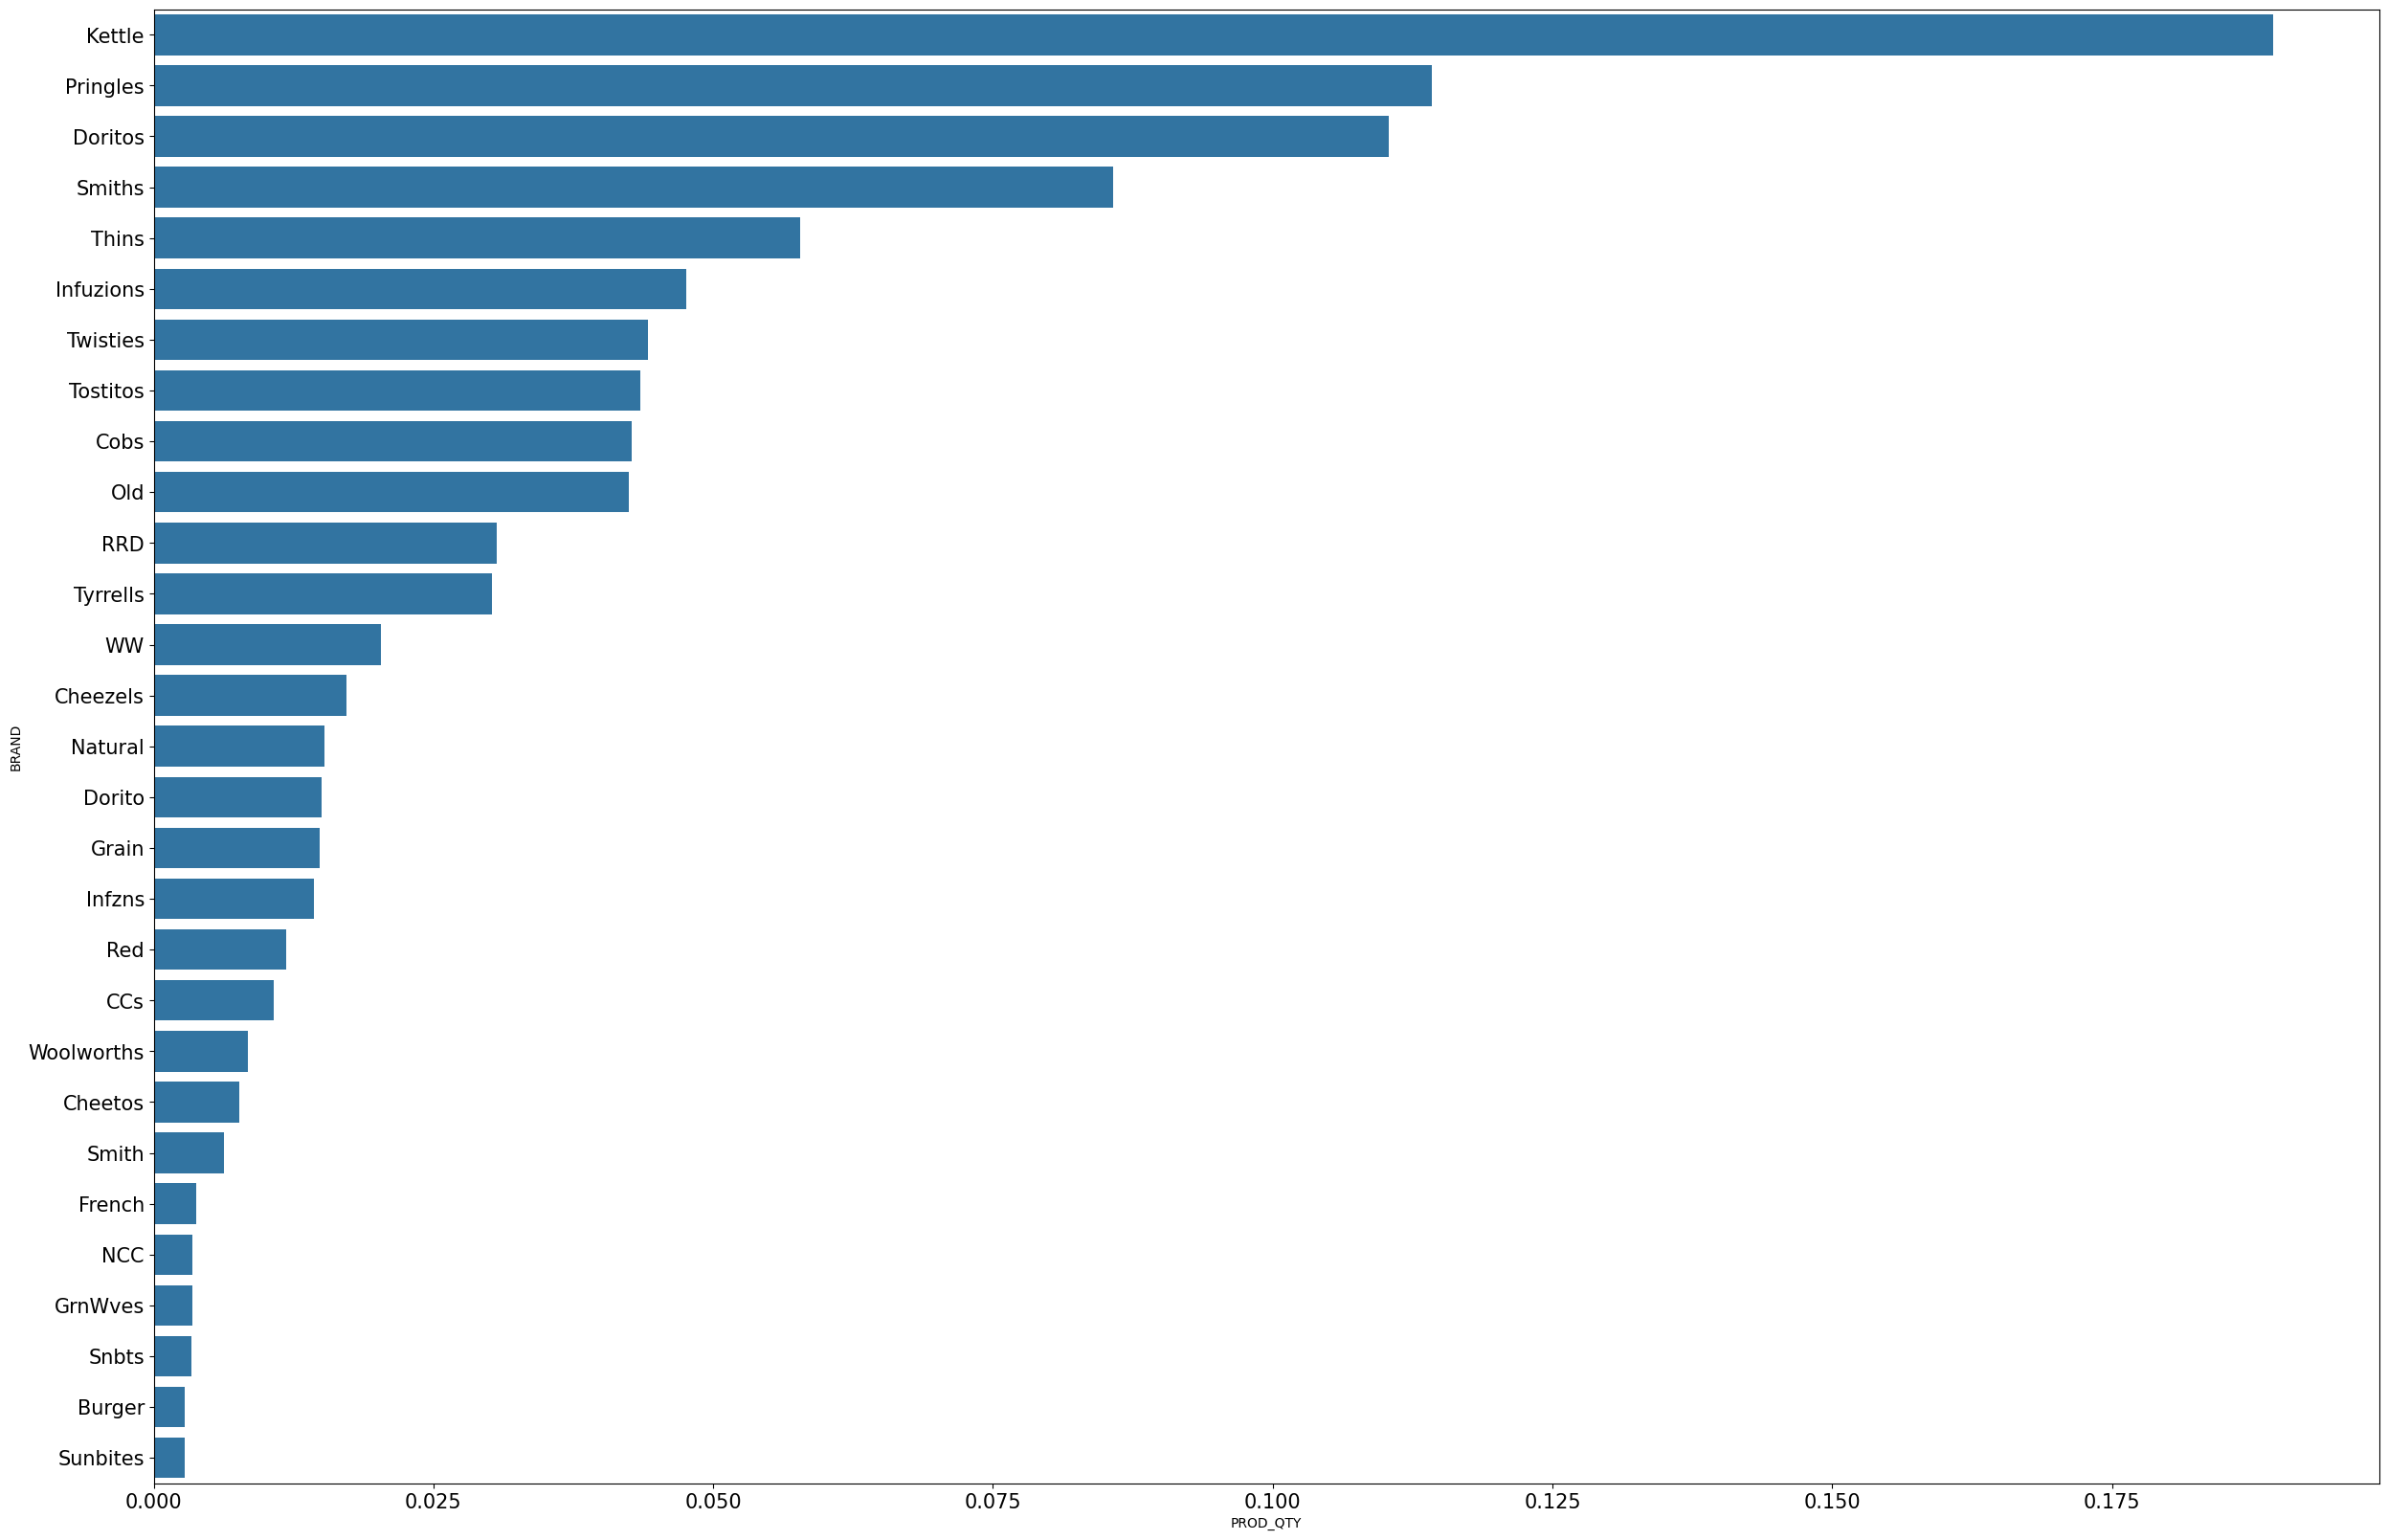

In [193]:
data = df[(df['LIFESTAGE']=='YOUNG SINGLES/COUPLES') & (df['PREMIUM_CUSTOMER']=='Mainstream')]
plt.figure(figsize=(30,20))

YC_affinity = (data.groupby(data['BRAND'])['PROD_QTY'].sum())/data['PROD_QTY'].sum()

sns.barplot(YC_affinity.sort_values(ascending=False), orient='h')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

In [201]:
(data.groupby(data['BRAND'])['PROD_QTY'].sum())/(data['PROD_QTY'].sum())

BRAND
Burger       0.00
CCs          0.01
Cheetos      0.01
Cheezels     0.02
Cobs         0.04
Dorito       0.02
Doritos      0.11
French       0.00
Grain        0.01
GrnWves      0.00
Infuzions    0.05
Infzns       0.01
Kettle       0.19
NCC          0.00
Natural      0.02
Old          0.04
Pringles     0.11
RRD          0.03
Red          0.01
Smith        0.01
Smiths       0.09
Snbts        0.00
Sunbites     0.00
Thins        0.06
Tostitos     0.04
Twisties     0.04
Tyrrells     0.03
WW           0.02
Woolworths   0.01
Name: PROD_QTY, dtype: float64

In [199]:
data['PROD_QTY'].sum()

37867

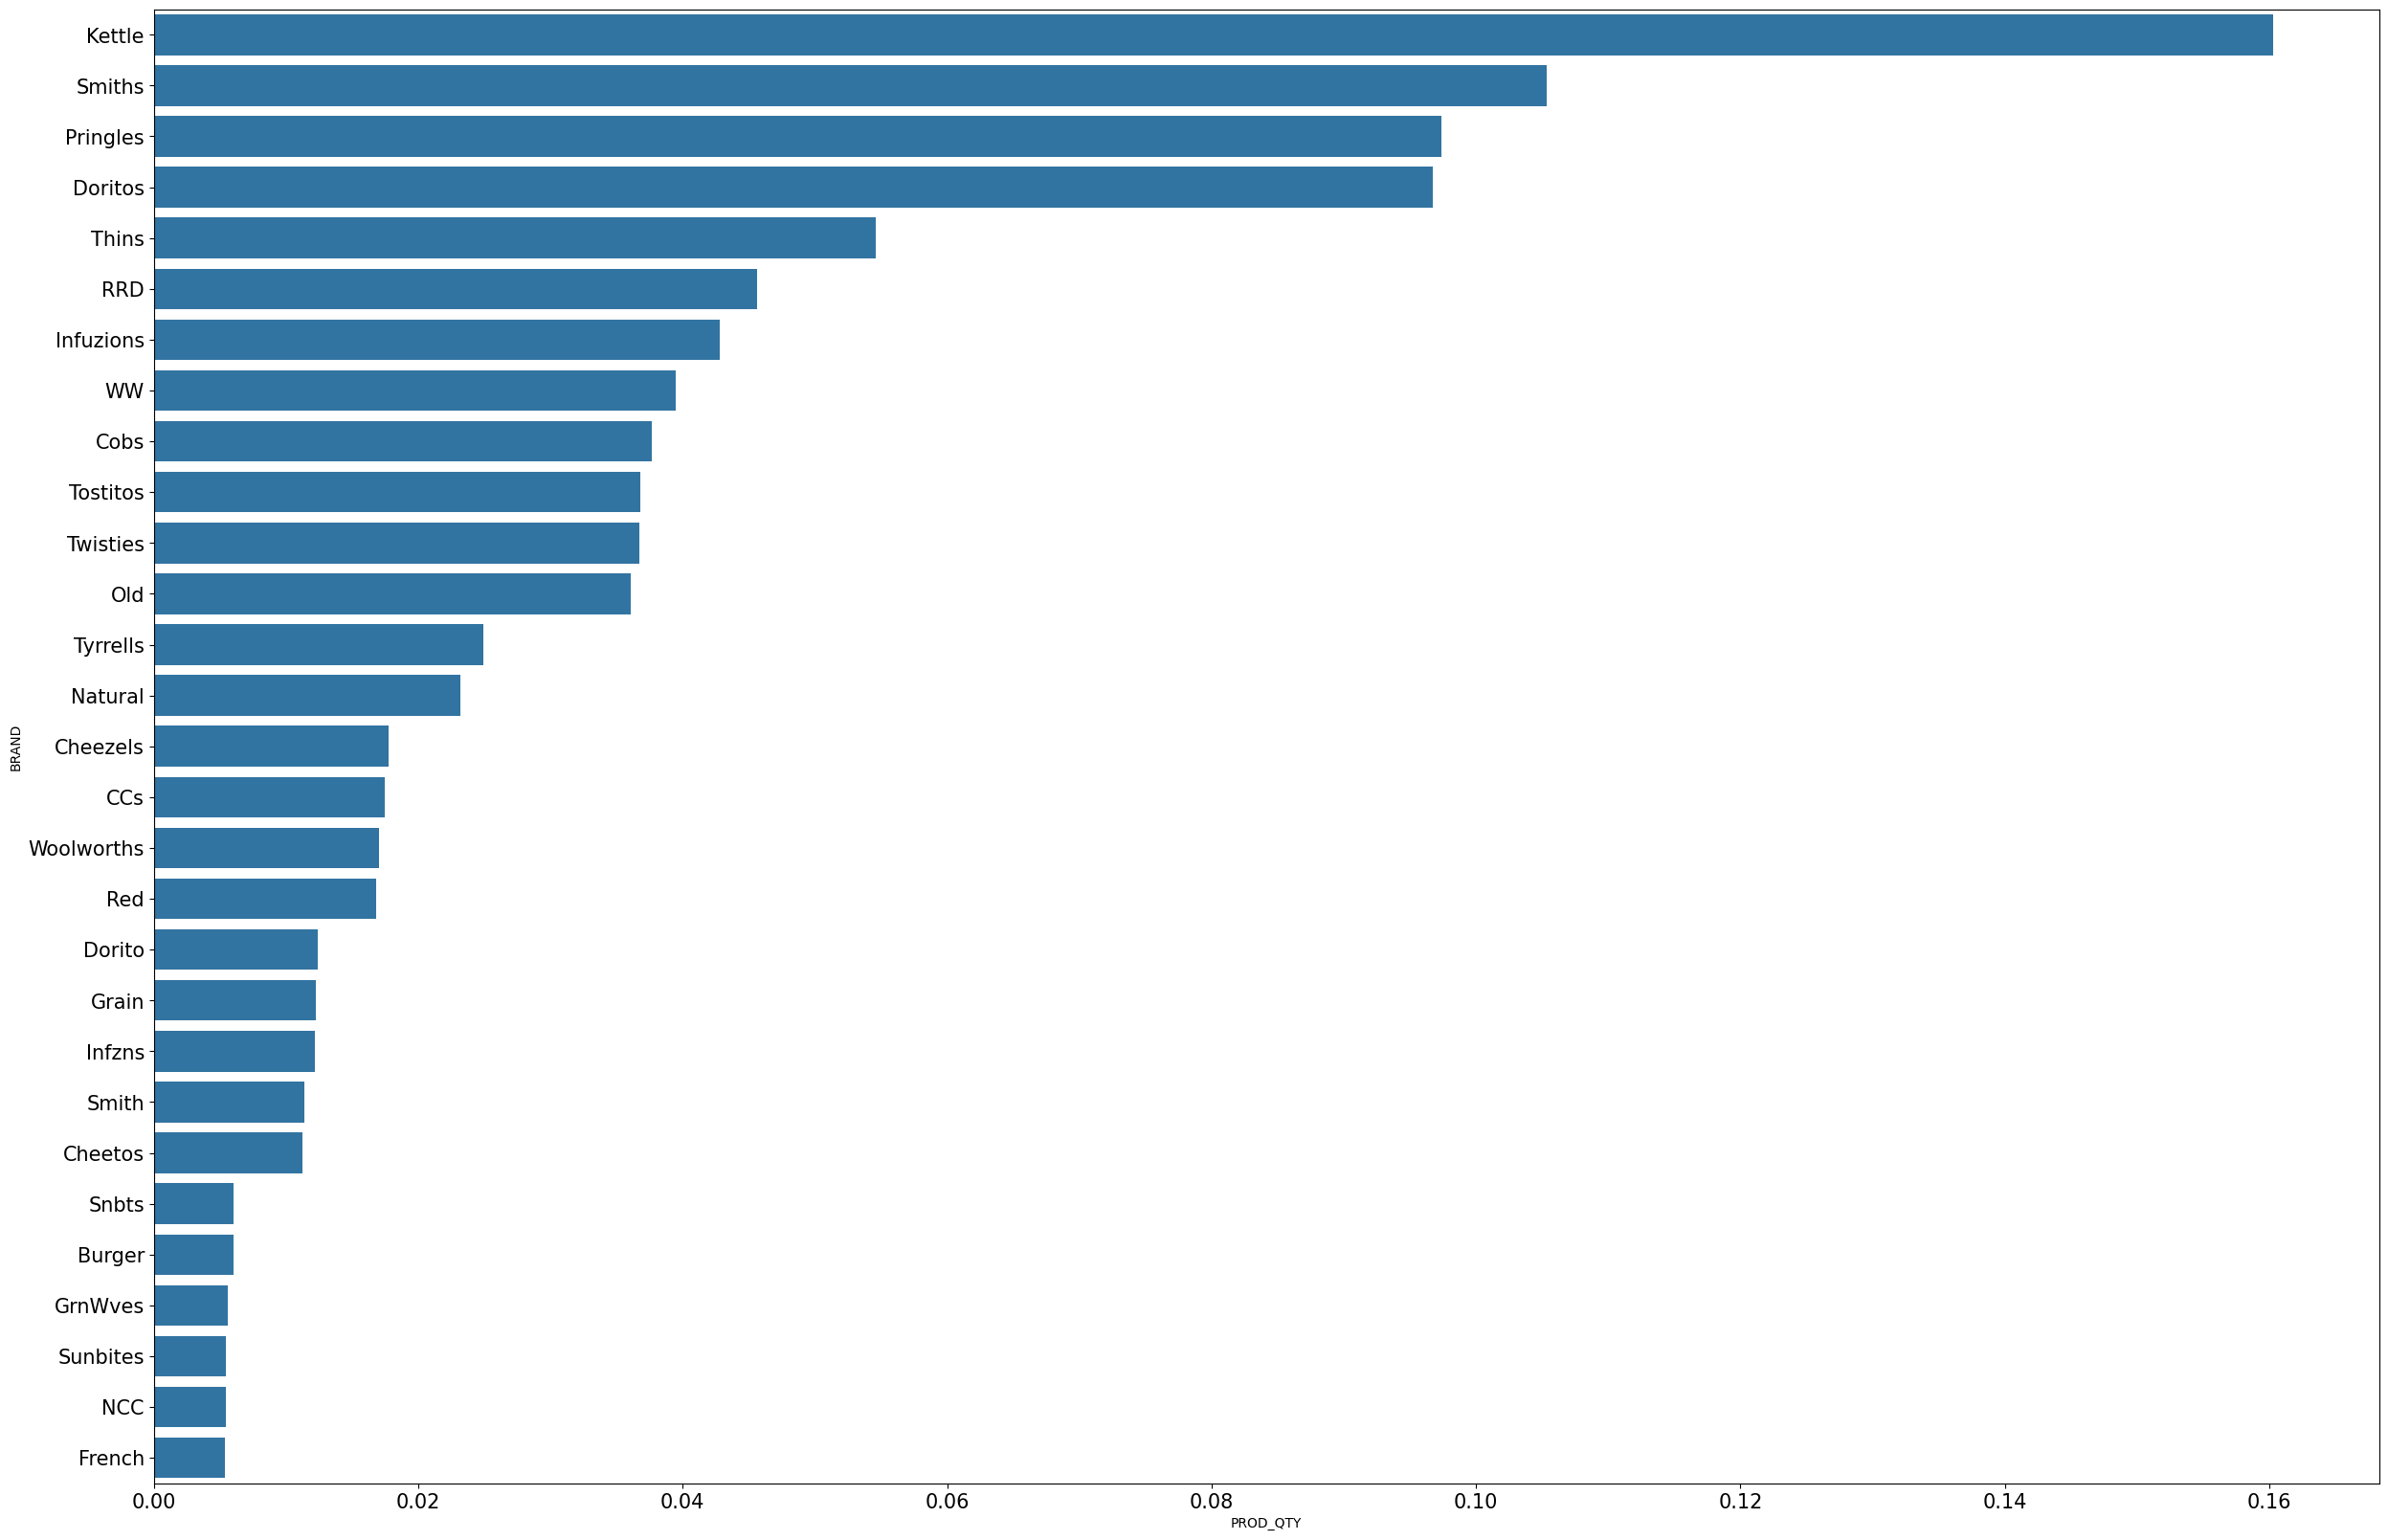

In [190]:
plt.figure(figsize=(30,20))
other_groups_affinity = df.groupby(df['BRAND'])['PROD_QTY'].sum()/df['PROD_QTY'].sum()
sns.barplot(other_groups_affinity.sort_values(ascending=False), orient='h')

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

In [204]:
(YC_affinity/other_groups_affinity).sort_values()

BRAND
Burger       0.46
Woolworths   0.49
Sunbites     0.50
WW           0.52
Snbts        0.55
Smith        0.55
GrnWves      0.61
CCs          0.61
NCC          0.64
Natural      0.66
RRD          0.67
Cheetos      0.69
Red          0.70
French       0.70
Smiths       0.81
Cheezels     0.97
Thins        1.06
Infuzions    1.11
Cobs         1.13
Doritos      1.14
Pringles     1.17
Infzns       1.17
Old          1.18
Tostitos     1.18
Kettle       1.18
Twisties     1.20
Grain        1.21
Tyrrells     1.21
Dorito       1.21
Name: PROD_QTY, dtype: float64

We can see that :
• Mainstream young singles/couples are 21% more likely to purchase Tyrrells chips compared to the
rest of the population
• Mainstream young singles/couples are 54% less likely to purchase Burger Rings compared to the rest
of the population

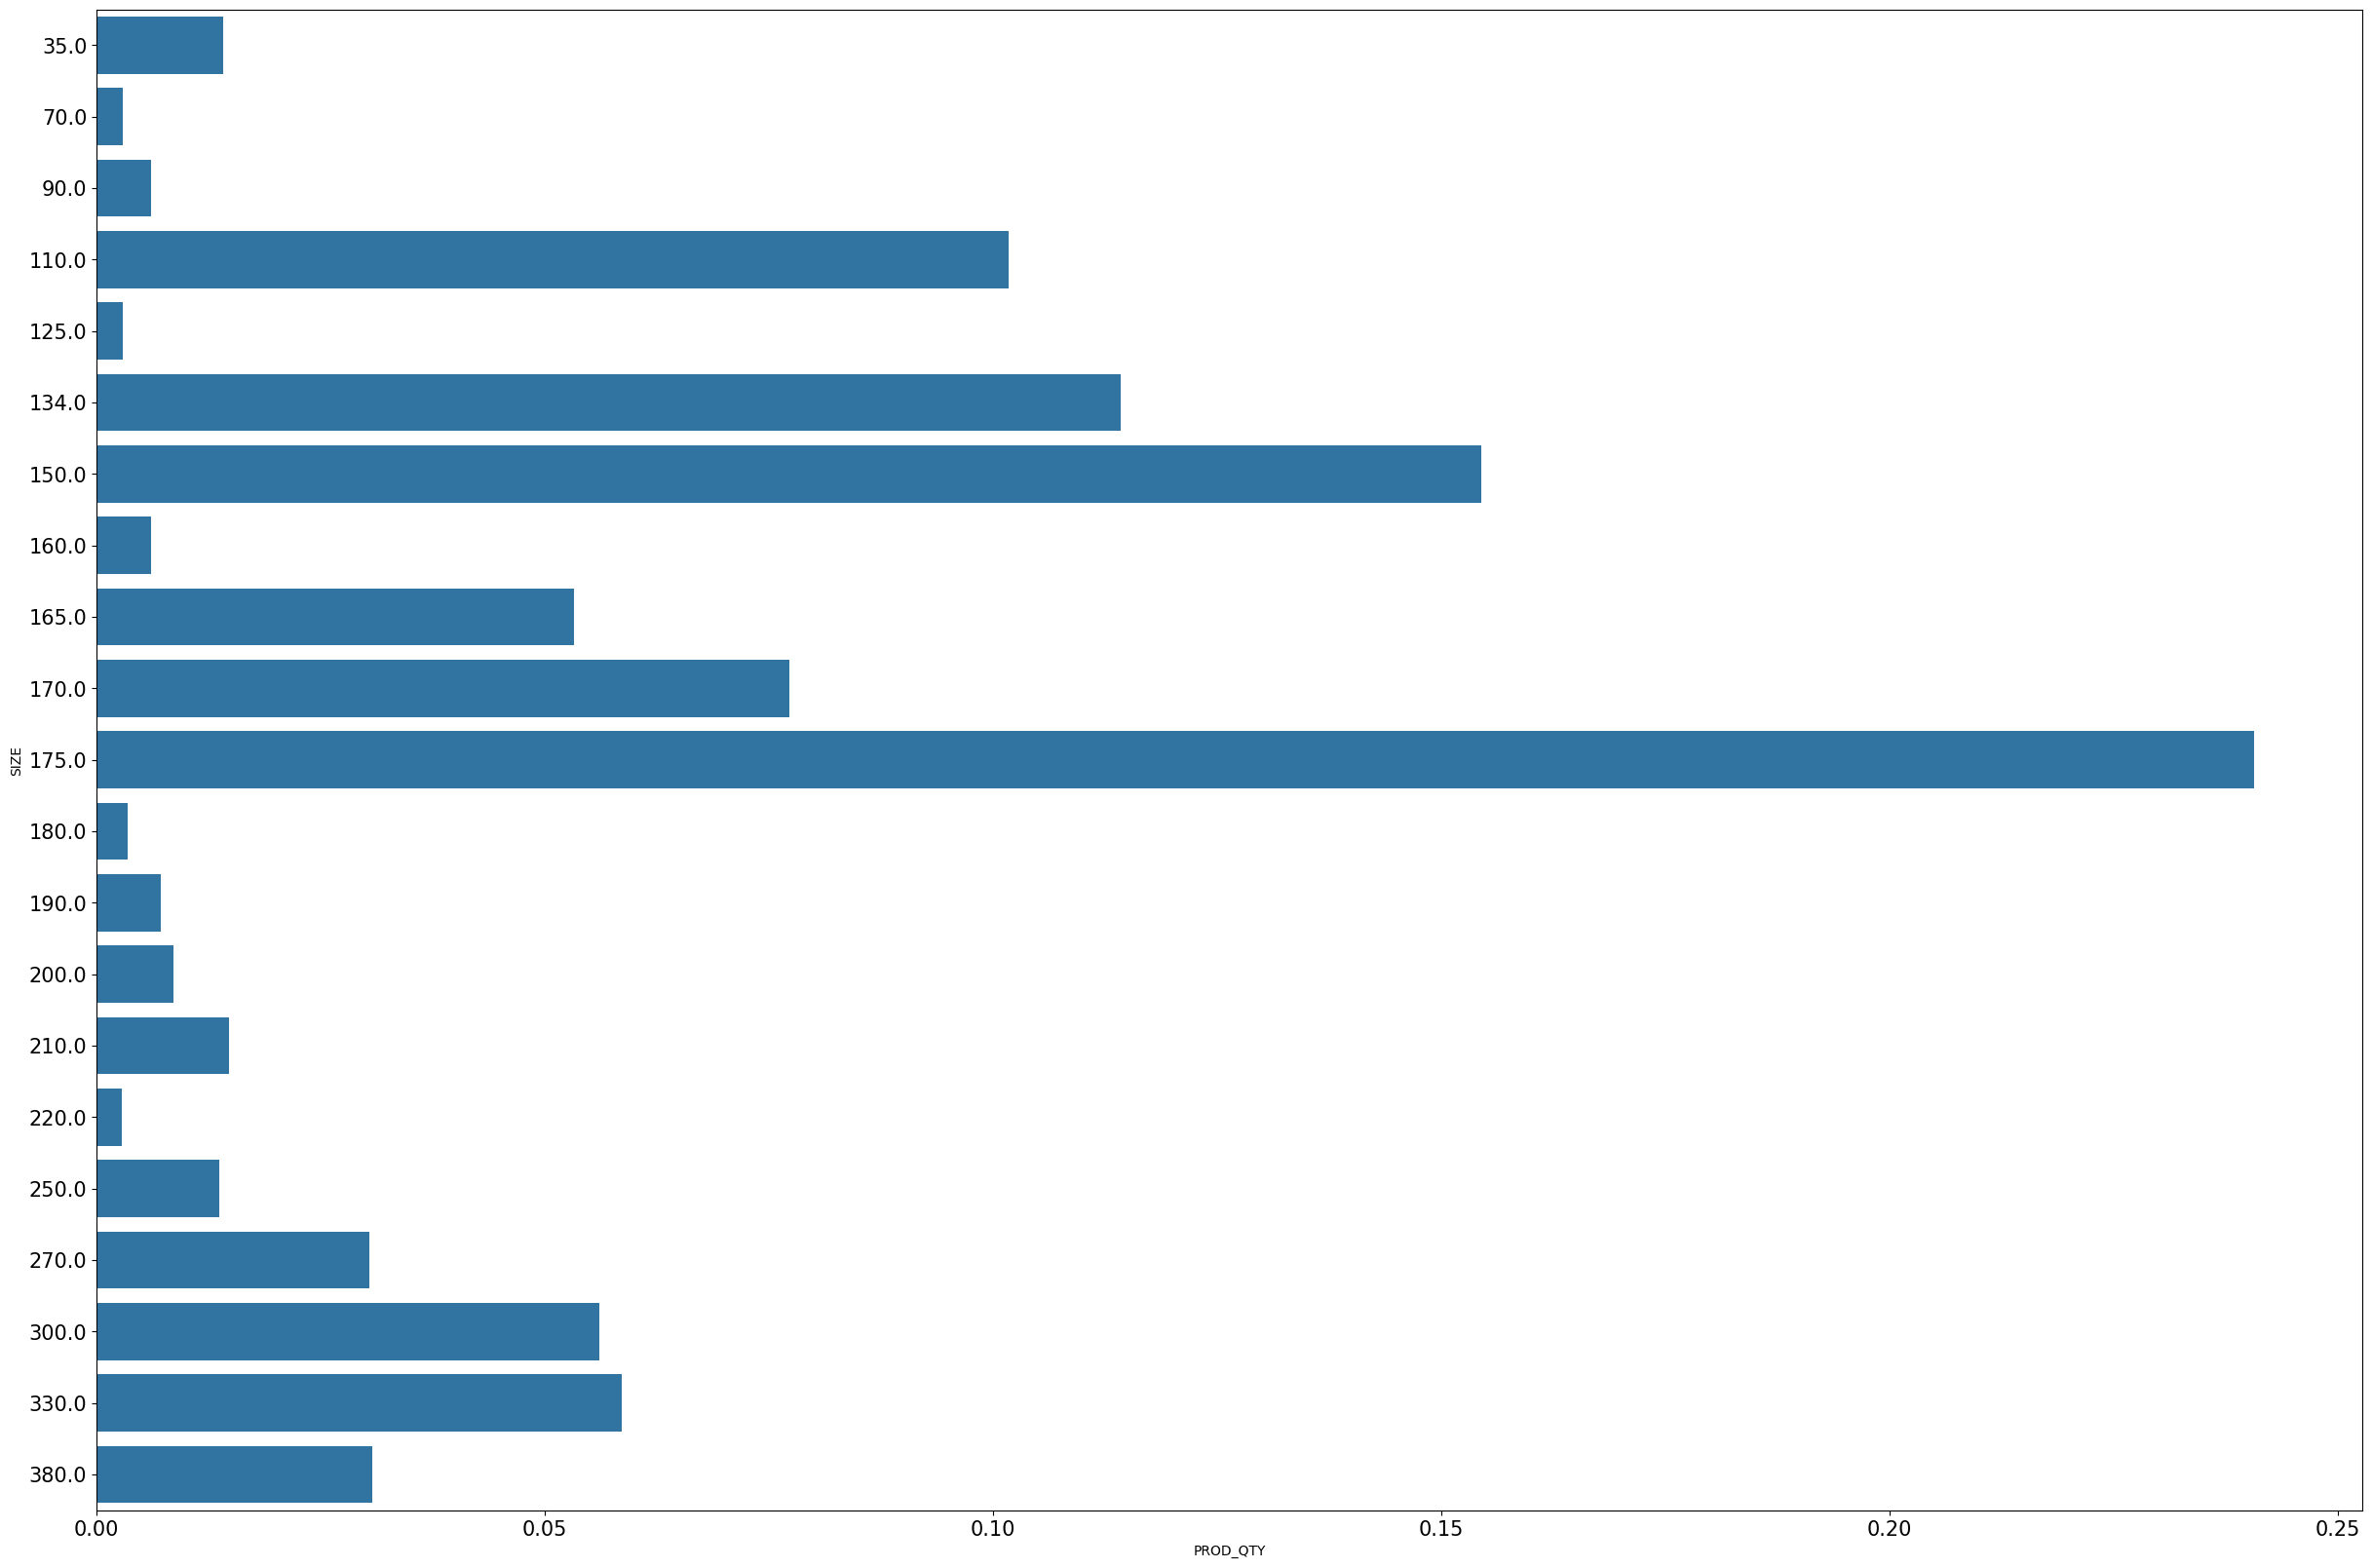

In [206]:
#Lets check which sizes of chip YC have high affinity for.
YC_affinity = (data.groupby(data['SIZE'])['PROD_QTY'].sum())/data['PROD_QTY'].sum()
plt.figure(figsize=(30,20))
sns.barplot(YC_affinity.sort_values(ascending=False), orient='h')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

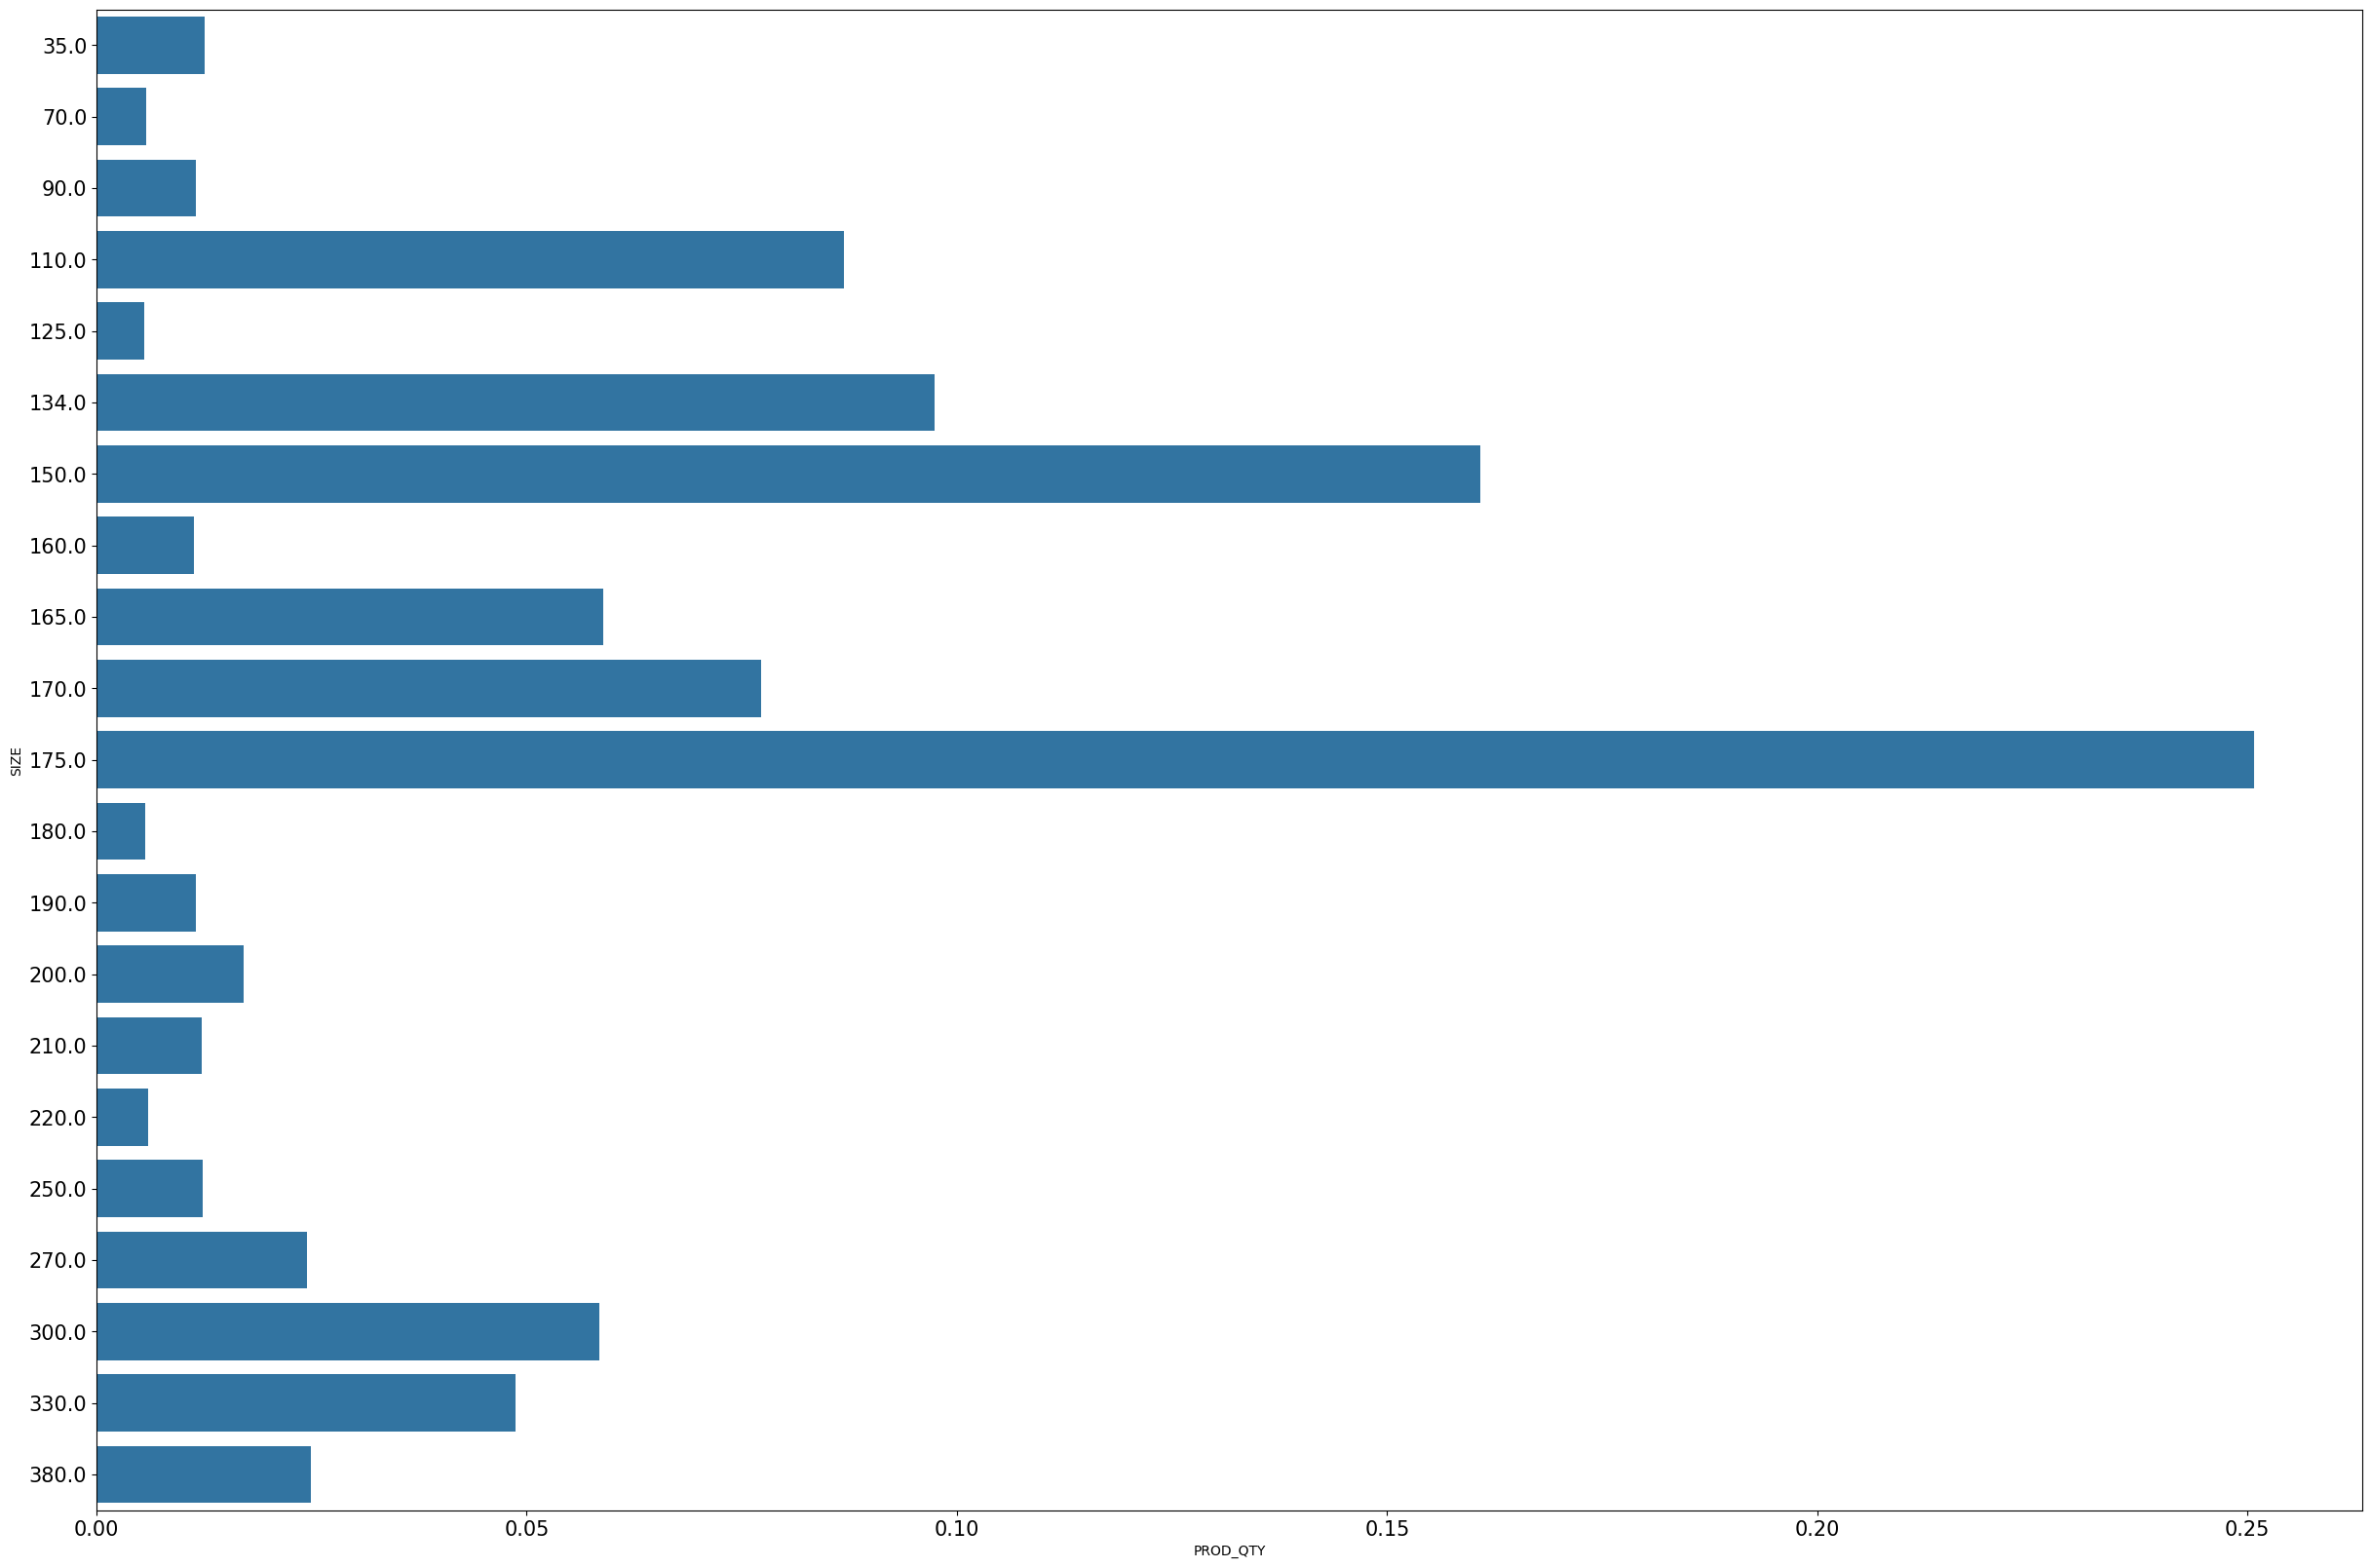

In [207]:
plt.figure(figsize=(30,20))
other_groups_affinity = df.groupby(df['SIZE'])['PROD_QTY'].sum()/df['PROD_QTY'].sum()
sns.barplot(other_groups_affinity.sort_values(ascending=False), orient='h')

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

In [208]:
(YC_affinity/other_groups_affinity).sort_values()

SIZE
220.00   0.46
70.00    0.50
200.00   0.50
125.00   0.52
90.00    0.53
160.00   0.54
180.00   0.61
190.00   0.62
165.00   0.90
175.00   0.96
300.00   0.96
150.00   0.96
170.00   1.00
250.00   1.12
35.00    1.12
110.00   1.17
134.00   1.17
330.00   1.20
210.00   1.21
380.00   1.24
270.00   1.25
Name: PROD_QTY, dtype: float64

Mainstream Young couples are 25% more affinity to buy 270g bag of chips. Let's see which brands have 270g bags

In [211]:
df[df['SIZE']==270]['PROD_NAME'].unique()

array(['Twisties Cheese     270g', 'Twisties Chicken270g'], dtype=object)

They are Twisties Cheese 270g, 'Twisties Chicken270g'



## Conclusion
Let’s recap what we’ve found!
Sales have mainly been due to Budget - older families, Mainstream - young singles/couples, and Mainstream retirees shoppers. We found that the high spend in chips for mainstream young singles/couples and retirees is due to there being more of them than other buyers. Mainstream, midage and young singles and
couples are also more likely to pay more per packet of chips. This is indicative of impulse buying behaviour.
We’ve also found that Mainstream young singles and couples are 23% more likely to purchase Tyrrells chips
compared to the rest of the population. The Category Manager may want to increase the category’s performance by off-locating some Tyrrells and smaller packs of chips in discretionary space near segments
where young singles and couples frequent more often to increase visibilty and impulse behaviour.